In [1]:
# # Dataset 압축해제
# !unzip x-ray.zip

## path 설정

In [2]:
import os
images_path = './images/'   # WGAN image 저장 폴더
models_path = './models/'   # 각 model 저장 폴더   
npy_path = './npy/'         # npy 배열 저장 폴더 
path_category_ = [images_path, models_path, npy_path]

for idx, folder in enumerate(path_category_) : 
    if os.path.isdir(folder) : 
        print(folder, 'Made')
    else : 
        os.mkdir(folder)
        print(folder, 'Make')

./images/ Made
./models/ Made
./npy/ Made


In [3]:
import shutil

# 이미지 path
fracture_path = './x-ray/fracture_resize_reverse_crop/'
normal_path = './x-ray/Normal_resize_reverse_crop/'

# 이미지 증강 path
generate_fracture_path = './x-ray/generate_fracture/'
generate_normal_path ='./x-ray/generate_normal/'
path_category = [generate_fracture_path, generate_normal_path]

# path folders Make 
for idx, folder in enumerate(path_category) :
    if os.path.isdir(folder) : 
        shutil.rmtree(folder)   # 폴더가 만들어져 있으면 기존의 폴더 지우고 
        os.mkdir(folder)        # 새로 생성함.
        print(folder, 'Folders Make!!')
    else : 
        os.mkdir(folder)        # 폴더가 없으면 새로 생성
        print(folder, 'Folders Make!!')

./x-ray/generate_fracture/ Folders Make!!
./x-ray/generate_normal/ Folders Make!!


## Data 전처리 
* 이미지 증강 X10
* 이미지 로드하면서 equalization 
* 로드된 이미지 numpy 배열변환
* -1~1 normalization 
* fracture only train - fracture_train.npy 
* normal only train - normal_train.npy 
* classification train - classify_train.npy (X_train_c, X_test, Y_train_c, Y_test)

In [4]:
import os, glob, sys, numpy as np
import cv2
import shutil

from PIL import Image
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


# images.shape = (None, 224, 244). value = 0~225
def equalize_images(images):
    return np.array([cv2.equalizeHist(image) for image in images])
    
def generate_images_for_data_augmentation(original_path, output_path, prefix, max_gen_count):
    #create_output_path(output_path)
    
    file_list = os.listdir(original_path)
    
    datagen = ImageDataGenerator(  
                rotation_range=10,
                width_shift_range=0.01,
                height_shift_range=0.01,
                #shear_range=0.2,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode="nearest")
    
    for filename in tqdm(file_list) :
        # copy
        shutil.copyfile(original_path + filename, output_path + filename)
        
        # generates
        img = load_img(original_path  + filename)  # this is a PIL image
        
        img_data = img_to_array(img) # this is a Numpy array
        img_data = img_data.reshape((1,) + img_data.shape)  # this is a Numpy array 

        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the `preview/` directory
        generated_count = 0
        
        for batch in datagen.flow(img_data, batch_size = 1, save_to_dir=output_path, save_prefix=prefix, save_format="jpg"):
            generated_count += 1

            if generated_count > max_gen_count:
                break  # otherwise the generator would loop indefinitely

Using TensorFlow backend.


In [5]:
# 이미지 증강
generate_images_for_data_augmentation(fracture_path, generate_fracture_path, '', 10)
generate_images_for_data_augmentation(normal_path, generate_normal_path, '', 10)

100%|██████████| 695/695 [00:21<00:00, 32.44it/s]


In [6]:
# GAN_Data_set - facture_only
X = []

for file_name in tqdm(glob.glob(generate_fracture_path + '*.jpg')) :
    img = Image.open(file_name).convert('L')
    data = np.array(img)
    # equalization
    data = equalize_images(data) 
    X.append(data)

fracture_train = np.array(X)
# normalization -1 ~ 1
fracture_train = (fracture_train - 127.5) / 127.5
print(fracture_train.shape)

100%|██████████| 8019/8019 [00:04<00:00, 1655.46it/s]


(8019, 128, 128, 1)


In [7]:
# fracutre_train 저장
np.save('./npy/fracture_train_127.npy',fracture_train)

In [8]:
# normal data set 
X_ = []

for file_name in tqdm(glob.glob(generate_normal_path + '*.jpg')) :
    img = Image.open(file_name).convert('L')
    data = np.array(img)
    # equalization
    data = equalize_images(data)
    X_.append(data)

normal_train = np.array(X_)
# normalization -1 ~ 1
normal_train = (normal_train - 127.5) / 127.5
print(normal_train.shape)

100%|██████████| 6010/6010 [00:03<00:00, 1671.11it/s]


(6010, 128, 128, 1)


In [9]:
# normal_train 저장
np.save('./npy/normal_train_127.npy',normal_train)

In [10]:
# Classfication 사용할 Data set 만들기
# fracture 와 normal data 1:1 비율

# normal_train 개수 확인 
train_len = normal_train.shape[0]
normal_train_x = normal_train

# facture data 개수를 Normal_data 개수와 맞추기 
fracture_train_x = fracture_train[ : train_len]

# y_label create
normal_train_y = np.zeros((train_len, 1)) # 비골절 0
fracture_train_y = np.ones((train_len, 1)) # 골절 1

print('normal data',normal_train_x.shape, normal_train_y.shape)
print('facture data',fracture_train_x.shape, fracture_train_y.shape)

normal data (6010, 128, 128, 1) (6010, 1)
facture data (6010, 128, 128, 1) (6010, 1)


In [11]:
# fracture + normal 
x = np.append(normal_train_x, fracture_train_x, axis = 0)
y = np.append(normal_train_y, fracture_train_y, axis = 0)

# data shuffle
shuffled_index = np.random.permutation(x.shape[0])
x = x[shuffled_index,:,:]
y = y[shuffled_index]

# data ready 
split_index = int(x.shape[0] * 0.9)
X_train_c, X_test = x[:split_index], x[split_index:]
Y_train_c, Y_test = y[:split_index], y[split_index:]

print('X_train', X_train_c.shape)
print('X_test ', X_test.shape)
print('Y_train', Y_train_c.shape)
print('Y_test ', Y_test.shape)

print(Y_test[:5]) # 0과 1이 섞여 있으면 suffle 성공

X_train (10818, 128, 128, 1)
X_test  (1202, 128, 128, 1)
Y_train (10818, 1)
Y_test  (1202, 1)
[[0.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [12]:
# classify_train 저장
xy = (X_train_c, X_test, Y_train_c, Y_test)
np.save('./npy/classify_train_127.npy', xy)

## WGAN 학습

In [13]:
import numpy as np 

fracture_train = np.load('./npy/fracture_train_127.npy', allow_pickle=True)

print(fracture_train.shape)

(8019, 128, 128, 1)


In [14]:
from __future__ import print_function, division

from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K
import matplotlib.pyplot as plt
import sys
import numpy as np

In [15]:
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    def __init__(self):
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        # Generate image based of noise (fake sample)
        fake_img = self.generator(z_disc)

        # Discriminator determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss, averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss, self.wasserstein_loss, partial_gp_loss],
                                  optimizer=optimizer,
                                  loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(self.latent_dim,))
        # Generate images based of noise
        img = self.generator(z_gen)
        # Discriminator determines validity
        valid = self.critic(img)
        # Defines generator model
        self.generator_model = Model(z_gen, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)


    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256 * 16 * 16, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((16, 16, 256)))
        model.add(UpSampling2D())
        
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())

        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())

        model.add(Conv2D(32, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))
        model.add(Activation('tanh')) #add

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, train_data, epochs, batch_size, sample_interval=50):

        # Load the dataset
        X_train = fracture_train

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, noise], [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.generator_model.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 3, 3
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/whole_%d.png" % epoch)
        plt.close()

In [16]:
wgan = WGANGP()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       524416    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 128)       0         
_______________________________________

In [17]:
# Wgan 학습
wgan.train(fracture_train, epochs=15000, batch_size=32, sample_interval=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/hiwony/.local/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/home/hiwony/.local/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 15.906847] [G loss: 0.868261]


/home/hiwony/.local/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 7.488294] [G loss: 0.982134]
2 [D loss: 9.482046] [G loss: 0.981687]
3 [D loss: 11.336236] [G loss: 0.984016]
4 [D loss: 9.386688] [G loss: 0.974752]
5 [D loss: 7.716283] [G loss: 0.959245]
6 [D loss: 8.613084] [G loss: 0.970819]
7 [D loss: 7.347048] [G loss: 0.939074]
8 [D loss: 11.152807] [G loss: 0.941447]
9 [D loss: 7.647552] [G loss: 0.975572]
10 [D loss: 8.510577] [G loss: 0.946468]
11 [D loss: 10.654507] [G loss: 0.981772]
12 [D loss: 9.173482] [G loss: 0.948714]
13 [D loss: 10.231186] [G loss: 0.988234]
14 [D loss: 7.847305] [G loss: 0.966998]
15 [D loss: 6.885180] [G loss: 0.893074]
16 [D loss: 7.714491] [G loss: 0.977363]
17 [D loss: 7.505837] [G loss: 0.975969]
18 [D loss: 9.133703] [G loss: 0.969780]
19 [D loss: 11.082602] [G loss: 0.889242]
20 [D loss: 8.895765] [G loss: 0.957025]
21 [D loss: 7.645492] [G loss: 0.902911]
22 [D loss: 9.032893] [G loss: 0.981388]
23 [D loss: 7.818440] [G loss: 0.920812]
24 [D loss: 15.674932] [G loss: 0.976276]
25 [D loss: 9.32097

198 [D loss: -0.178690] [G loss: 0.824779]
199 [D loss: -0.145834] [G loss: 0.886327]
200 [D loss: -0.171430] [G loss: 0.625157]
201 [D loss: -0.122544] [G loss: 0.462504]
202 [D loss: -0.299128] [G loss: 0.717159]
203 [D loss: 0.155075] [G loss: 0.890164]
204 [D loss: -0.010122] [G loss: 0.750746]
205 [D loss: 0.026473] [G loss: 0.690968]
206 [D loss: -0.488625] [G loss: 0.706892]
207 [D loss: -0.542305] [G loss: 0.594232]
208 [D loss: 0.182929] [G loss: 0.752315]
209 [D loss: -0.500935] [G loss: 0.750126]
210 [D loss: 0.129260] [G loss: 0.374560]
211 [D loss: -0.327169] [G loss: 0.888228]
212 [D loss: -0.719596] [G loss: 0.912921]
213 [D loss: -0.385638] [G loss: 0.770620]
214 [D loss: -0.499606] [G loss: 0.887506]
215 [D loss: -0.738796] [G loss: 0.462224]
216 [D loss: -0.460304] [G loss: 0.937245]
217 [D loss: -0.939604] [G loss: 0.641096]
218 [D loss: -0.397578] [G loss: 0.870631]
219 [D loss: -0.518131] [G loss: 0.560677]
220 [D loss: 2.024642] [G loss: 0.715694]
221 [D loss: -0.

390 [D loss: -0.424920] [G loss: 0.513924]
391 [D loss: -0.491015] [G loss: 0.409347]
392 [D loss: -0.579991] [G loss: 0.208985]
393 [D loss: -0.855662] [G loss: 0.295790]
394 [D loss: -0.330811] [G loss: 0.572867]
395 [D loss: -0.634877] [G loss: 0.339489]
396 [D loss: -0.073594] [G loss: -0.382064]
397 [D loss: -0.498317] [G loss: 0.330066]
398 [D loss: -0.339187] [G loss: 0.397872]
399 [D loss: -0.686423] [G loss: 0.310178]
400 [D loss: -0.593123] [G loss: -0.019553]
401 [D loss: -0.332174] [G loss: 0.231439]
402 [D loss: -0.408034] [G loss: 0.414641]
403 [D loss: -0.297832] [G loss: 0.510669]
404 [D loss: -0.132986] [G loss: 0.191279]
405 [D loss: -0.882927] [G loss: 0.446301]
406 [D loss: -0.244608] [G loss: 0.088383]
407 [D loss: -0.523769] [G loss: 0.410558]
408 [D loss: -0.496622] [G loss: 0.251090]
409 [D loss: -0.625999] [G loss: 0.277217]
410 [D loss: -0.439712] [G loss: -0.093186]
411 [D loss: -0.428817] [G loss: 0.757754]
412 [D loss: -0.381705] [G loss: 0.417076]
413 [D l

581 [D loss: -0.878832] [G loss: 0.335147]
582 [D loss: -0.048478] [G loss: -0.018003]
583 [D loss: -0.644748] [G loss: 0.397243]
584 [D loss: -0.833215] [G loss: 0.455557]
585 [D loss: -0.400020] [G loss: -0.021603]
586 [D loss: -0.606575] [G loss: -0.152278]
587 [D loss: -0.296407] [G loss: 0.110576]
588 [D loss: -0.461919] [G loss: 0.355287]
589 [D loss: -0.737510] [G loss: 0.655839]
590 [D loss: -0.416077] [G loss: -0.058741]
591 [D loss: 0.109749] [G loss: -0.381476]
592 [D loss: -0.447459] [G loss: 0.306996]
593 [D loss: -0.387039] [G loss: 0.189626]
594 [D loss: -0.849318] [G loss: 0.277708]
595 [D loss: -0.546995] [G loss: 0.403348]
596 [D loss: -0.578762] [G loss: -0.081748]
597 [D loss: -0.245487] [G loss: 0.118586]
598 [D loss: 1.194578] [G loss: -0.165595]
599 [D loss: -0.728177] [G loss: 0.012741]
600 [D loss: -0.439423] [G loss: 0.042813]
601 [D loss: 0.289312] [G loss: -0.449996]
602 [D loss: -0.487675] [G loss: 0.094195]
603 [D loss: -0.395414] [G loss: 0.510702]
604 [D

771 [D loss: 1.633363] [G loss: -0.540115]
772 [D loss: -0.337950] [G loss: -0.213030]
773 [D loss: 0.286008] [G loss: -0.046601]
774 [D loss: -0.221575] [G loss: 0.373135]
775 [D loss: -0.655904] [G loss: 0.528992]
776 [D loss: -0.294958] [G loss: 0.374948]
777 [D loss: -0.206899] [G loss: 0.186805]
778 [D loss: -0.265286] [G loss: 0.272938]
779 [D loss: -0.489175] [G loss: -0.295847]
780 [D loss: -0.284623] [G loss: 0.081533]
781 [D loss: -0.505674] [G loss: 0.028643]
782 [D loss: 0.319220] [G loss: 0.146846]
783 [D loss: -0.508913] [G loss: 0.074738]
784 [D loss: -0.062512] [G loss: 0.499659]
785 [D loss: -0.302074] [G loss: 0.024228]
786 [D loss: -0.412314] [G loss: 0.355405]
787 [D loss: -0.271758] [G loss: 0.170511]
788 [D loss: -0.250064] [G loss: -0.040460]
789 [D loss: -0.532880] [G loss: 0.249726]
790 [D loss: -0.512070] [G loss: 0.320761]
791 [D loss: -0.819473] [G loss: 0.195932]
792 [D loss: -0.520258] [G loss: -0.055349]
793 [D loss: -0.344570] [G loss: 0.054827]
794 [D l

961 [D loss: -0.153610] [G loss: -0.432213]
962 [D loss: -0.336095] [G loss: 0.131164]
963 [D loss: -0.034196] [G loss: -0.020937]
964 [D loss: -0.877482] [G loss: 0.451730]
965 [D loss: -0.279105] [G loss: -0.027096]
966 [D loss: -0.541133] [G loss: -0.080950]
967 [D loss: -0.364647] [G loss: 0.103120]
968 [D loss: -0.731066] [G loss: 0.336574]
969 [D loss: -0.212360] [G loss: -0.277423]
970 [D loss: -0.502346] [G loss: 0.274109]
971 [D loss: -0.114574] [G loss: -0.288753]
972 [D loss: 0.114293] [G loss: -0.080139]
973 [D loss: -0.540626] [G loss: 0.097706]
974 [D loss: -0.409935] [G loss: 0.098861]
975 [D loss: -0.198589] [G loss: 0.674722]
976 [D loss: -0.123495] [G loss: 0.195706]
977 [D loss: -0.395742] [G loss: 0.001506]
978 [D loss: -0.484304] [G loss: -0.433690]
979 [D loss: -0.235892] [G loss: 0.052757]
980 [D loss: -0.181818] [G loss: -0.147370]
981 [D loss: 0.360385] [G loss: 0.537487]
982 [D loss: -0.543838] [G loss: 0.233697]
983 [D loss: -0.161067] [G loss: 0.105907]
984 

1148 [D loss: -0.424421] [G loss: -0.201602]
1149 [D loss: -0.450083] [G loss: -0.283904]
1150 [D loss: -0.343518] [G loss: -0.048988]
1151 [D loss: -0.431002] [G loss: 0.138616]
1152 [D loss: -0.189031] [G loss: -0.553926]
1153 [D loss: -0.329552] [G loss: -0.045240]
1154 [D loss: -0.104586] [G loss: -0.251124]
1155 [D loss: -0.051841] [G loss: -0.127448]
1156 [D loss: 0.171199] [G loss: -0.145447]
1157 [D loss: -0.357746] [G loss: 0.174463]
1158 [D loss: -0.096334] [G loss: 0.221868]
1159 [D loss: -0.524744] [G loss: 0.137410]
1160 [D loss: -0.380434] [G loss: 0.136285]
1161 [D loss: -0.180026] [G loss: -0.572785]
1162 [D loss: -0.119657] [G loss: -0.363170]
1163 [D loss: -0.401158] [G loss: -0.018944]
1164 [D loss: -0.197587] [G loss: 0.598827]
1165 [D loss: -0.281046] [G loss: -0.287840]
1166 [D loss: -0.755890] [G loss: 0.300683]
1167 [D loss: -0.460270] [G loss: 0.102535]
1168 [D loss: -0.161561] [G loss: -0.081833]
1169 [D loss: 0.083979] [G loss: -0.355191]
1170 [D loss: -0.056

1334 [D loss: -0.503668] [G loss: 0.133348]
1335 [D loss: -0.419622] [G loss: 0.151598]
1336 [D loss: -0.584922] [G loss: 0.165116]
1337 [D loss: -0.242245] [G loss: 0.019092]
1338 [D loss: -0.015970] [G loss: -0.338076]
1339 [D loss: -0.542454] [G loss: 0.258701]
1340 [D loss: -0.383084] [G loss: 0.049108]
1341 [D loss: 0.565889] [G loss: -0.040104]
1342 [D loss: -0.126565] [G loss: 0.097603]
1343 [D loss: -0.197749] [G loss: 0.145287]
1344 [D loss: -0.391731] [G loss: 0.214801]
1345 [D loss: -0.331906] [G loss: 0.164680]
1346 [D loss: -0.207837] [G loss: -0.240731]
1347 [D loss: -0.327805] [G loss: 0.143633]
1348 [D loss: -0.617867] [G loss: 0.202992]
1349 [D loss: -0.615222] [G loss: 0.305809]
1350 [D loss: -0.286347] [G loss: 0.089066]
1351 [D loss: -0.531293] [G loss: 0.293911]
1352 [D loss: -0.415048] [G loss: -0.033555]
1353 [D loss: -0.381831] [G loss: 0.357564]
1354 [D loss: -0.243921] [G loss: -0.068053]
1355 [D loss: -0.388784] [G loss: 0.230525]
1356 [D loss: 0.946366] [G l

1520 [D loss: -0.290769] [G loss: -0.226274]
1521 [D loss: -0.552137] [G loss: 0.238625]
1522 [D loss: -0.525441] [G loss: 0.254835]
1523 [D loss: -0.644989] [G loss: 0.524758]
1524 [D loss: -0.589375] [G loss: 0.429151]
1525 [D loss: -0.338080] [G loss: 0.077196]
1526 [D loss: -0.171142] [G loss: 0.513739]
1527 [D loss: -0.603961] [G loss: 0.204259]
1528 [D loss: -0.359034] [G loss: 0.094901]
1529 [D loss: 0.777217] [G loss: 0.094072]
1530 [D loss: -0.406842] [G loss: 0.376680]
1531 [D loss: -0.597346] [G loss: 0.235473]
1532 [D loss: -0.469611] [G loss: -0.167875]
1533 [D loss: -0.521335] [G loss: 0.006790]
1534 [D loss: -0.257678] [G loss: 0.166682]
1535 [D loss: -0.576937] [G loss: -0.101825]
1536 [D loss: -0.413518] [G loss: 0.135285]
1537 [D loss: -0.688881] [G loss: 0.036371]
1538 [D loss: -0.503718] [G loss: 0.214341]
1539 [D loss: -0.358818] [G loss: 0.205104]
1540 [D loss: -0.607877] [G loss: 0.313753]
1541 [D loss: 0.174187] [G loss: -0.099080]
1542 [D loss: -0.459979] [G lo

1706 [D loss: -0.278977] [G loss: 0.318659]
1707 [D loss: -0.536915] [G loss: 0.258145]
1708 [D loss: 0.105403] [G loss: 0.074012]
1709 [D loss: -0.613955] [G loss: 0.331476]
1710 [D loss: -0.302735] [G loss: 0.077387]
1711 [D loss: -0.368494] [G loss: 0.176355]
1712 [D loss: -0.304305] [G loss: 0.279490]
1713 [D loss: -0.413028] [G loss: 0.080423]
1714 [D loss: -0.420141] [G loss: -0.009766]
1715 [D loss: -0.656436] [G loss: 0.210583]
1716 [D loss: -0.321823] [G loss: 0.178851]
1717 [D loss: 0.028869] [G loss: 0.003627]
1718 [D loss: -0.921281] [G loss: 0.339088]
1719 [D loss: -0.156966] [G loss: 0.008884]
1720 [D loss: -0.529974] [G loss: 0.138624]
1721 [D loss: -0.445493] [G loss: 0.514701]
1722 [D loss: -0.542064] [G loss: 0.044943]
1723 [D loss: -0.678121] [G loss: 0.435160]
1724 [D loss: -0.412909] [G loss: -0.004909]
1725 [D loss: -0.500549] [G loss: -0.059791]
1726 [D loss: -0.467524] [G loss: 0.147297]
1727 [D loss: -0.574007] [G loss: 0.271886]
1728 [D loss: -0.569155] [G los

1892 [D loss: -0.726657] [G loss: 0.510260]
1893 [D loss: -0.940349] [G loss: 0.578521]
1894 [D loss: -0.951458] [G loss: 0.837520]
1895 [D loss: -0.798410] [G loss: 0.041211]
1896 [D loss: -0.554195] [G loss: -0.273752]
1897 [D loss: -0.399132] [G loss: 0.101647]
1898 [D loss: -0.650934] [G loss: 0.153205]
1899 [D loss: -0.530246] [G loss: 0.140835]
1900 [D loss: -0.208230] [G loss: -0.000890]
1901 [D loss: -0.187950] [G loss: 0.024966]
1902 [D loss: -1.027109] [G loss: 0.431715]
1903 [D loss: -0.769407] [G loss: 0.484569]
1904 [D loss: -0.461127] [G loss: 0.117693]
1905 [D loss: -1.026821] [G loss: 0.572978]
1906 [D loss: -0.519154] [G loss: -0.076083]
1907 [D loss: -0.630144] [G loss: 0.358355]
1908 [D loss: -0.560169] [G loss: 0.529730]
1909 [D loss: -0.884588] [G loss: 0.155350]
1910 [D loss: -0.512192] [G loss: 0.184044]
1911 [D loss: -0.657754] [G loss: 0.081910]
1912 [D loss: -0.433640] [G loss: 0.256038]
1913 [D loss: -0.635924] [G loss: 0.167588]
1914 [D loss: -1.050704] [G l

2078 [D loss: -0.626757] [G loss: 0.165539]
2079 [D loss: -0.946677] [G loss: 0.356417]
2080 [D loss: -0.912928] [G loss: 0.755866]
2081 [D loss: -0.928539] [G loss: 0.439481]
2082 [D loss: -0.607340] [G loss: 0.230380]
2083 [D loss: -0.950859] [G loss: 0.426195]
2084 [D loss: -1.065410] [G loss: 0.693698]
2085 [D loss: -0.971947] [G loss: 0.608908]
2086 [D loss: -0.905970] [G loss: 0.293929]
2087 [D loss: -0.792970] [G loss: 0.499282]
2088 [D loss: -0.584854] [G loss: -0.132033]
2089 [D loss: -0.323732] [G loss: -0.267623]
2090 [D loss: -0.613593] [G loss: 0.235316]
2091 [D loss: -0.790851] [G loss: 0.574751]
2092 [D loss: -0.853397] [G loss: 0.747850]
2093 [D loss: -0.886906] [G loss: 0.128520]
2094 [D loss: 1.977057] [G loss: 0.120313]
2095 [D loss: -0.539295] [G loss: -0.107650]
2096 [D loss: -0.850631] [G loss: -0.018994]
2097 [D loss: -0.436717] [G loss: 0.089264]
2098 [D loss: -0.166132] [G loss: 0.026364]
2099 [D loss: -0.923723] [G loss: 0.463371]
2100 [D loss: -0.681182] [G l

2264 [D loss: -0.843315] [G loss: 0.561379]
2265 [D loss: -0.899693] [G loss: 0.222160]
2266 [D loss: -0.696059] [G loss: 0.582396]
2267 [D loss: -0.729843] [G loss: 0.300426]
2268 [D loss: -0.857833] [G loss: 0.454542]
2269 [D loss: -0.455869] [G loss: -0.043527]
2270 [D loss: -0.773304] [G loss: 0.254086]
2271 [D loss: -0.679330] [G loss: 0.201701]
2272 [D loss: -0.801410] [G loss: 0.393072]
2273 [D loss: 0.128056] [G loss: 0.116776]
2274 [D loss: -0.783921] [G loss: 0.372252]
2275 [D loss: -0.961002] [G loss: 0.356575]
2276 [D loss: -0.421112] [G loss: 0.103911]
2277 [D loss: -0.501168] [G loss: 0.456916]
2278 [D loss: -0.545260] [G loss: 0.395663]
2279 [D loss: -0.068323] [G loss: -0.298806]
2280 [D loss: -0.690666] [G loss: 0.011838]
2281 [D loss: -0.865831] [G loss: 0.362610]
2282 [D loss: -0.408918] [G loss: 0.547462]
2283 [D loss: 0.449936] [G loss: 0.205956]
2284 [D loss: -0.436806] [G loss: -0.125521]
2285 [D loss: -0.510634] [G loss: -0.287669]
2286 [D loss: -0.574093] [G lo

2450 [D loss: -0.976700] [G loss: 0.508888]
2451 [D loss: -0.725551] [G loss: 0.451675]
2452 [D loss: -0.539777] [G loss: 0.220617]
2453 [D loss: -0.719912] [G loss: 0.334904]
2454 [D loss: -0.936307] [G loss: 0.512742]
2455 [D loss: -0.874695] [G loss: 0.325887]
2456 [D loss: -0.966565] [G loss: 0.446027]
2457 [D loss: -0.765188] [G loss: 0.259834]
2458 [D loss: -0.871992] [G loss: 0.364644]
2459 [D loss: -0.473134] [G loss: 0.297304]
2460 [D loss: -0.878339] [G loss: 0.557452]
2461 [D loss: -0.465378] [G loss: 0.260070]
2462 [D loss: 0.220730] [G loss: 0.305012]
2463 [D loss: -0.422233] [G loss: -0.021323]
2464 [D loss: -0.270781] [G loss: 0.511150]
2465 [D loss: -0.132470] [G loss: 0.404024]
2466 [D loss: -0.426678] [G loss: 0.223538]
2467 [D loss: -0.651794] [G loss: 0.398915]
2468 [D loss: -0.612114] [G loss: -0.121503]
2469 [D loss: -0.329630] [G loss: -0.026880]
2470 [D loss: -0.836606] [G loss: 0.318923]
2471 [D loss: -0.580855] [G loss: -0.150105]
2472 [D loss: -0.407319] [G l

2636 [D loss: 1.160833] [G loss: 0.270270]
2637 [D loss: -0.707429] [G loss: 0.305365]
2638 [D loss: -0.733460] [G loss: 0.213240]
2639 [D loss: -0.690034] [G loss: 0.107909]
2640 [D loss: -0.482710] [G loss: -0.068677]
2641 [D loss: -0.567208] [G loss: 0.113460]
2642 [D loss: -0.778374] [G loss: 0.591344]
2643 [D loss: -0.727386] [G loss: 0.107199]
2644 [D loss: -0.538045] [G loss: -0.023346]
2645 [D loss: -0.795019] [G loss: 0.351825]
2646 [D loss: -0.640096] [G loss: 0.802539]
2647 [D loss: -0.529568] [G loss: 0.052682]
2648 [D loss: -0.986473] [G loss: 0.429683]
2649 [D loss: -0.721202] [G loss: 0.201677]
2650 [D loss: -0.972417] [G loss: 0.448500]
2651 [D loss: -0.871269] [G loss: 0.345743]
2652 [D loss: -0.989451] [G loss: 0.481814]
2653 [D loss: 0.005791] [G loss: 0.442595]
2654 [D loss: -0.624350] [G loss: 0.008776]
2655 [D loss: -0.374059] [G loss: -0.147015]
2656 [D loss: -0.793399] [G loss: 0.474342]
2657 [D loss: -0.767838] [G loss: 0.410593]
2658 [D loss: -0.125782] [G los

2822 [D loss: -0.728151] [G loss: 0.172550]
2823 [D loss: -0.910438] [G loss: 0.458252]
2824 [D loss: -0.687141] [G loss: 0.432351]
2825 [D loss: -0.629736] [G loss: 0.065189]
2826 [D loss: -0.914806] [G loss: 0.328944]
2827 [D loss: -1.020812] [G loss: 0.472417]
2828 [D loss: -1.124910] [G loss: 0.177822]
2829 [D loss: -0.919804] [G loss: 0.341844]
2830 [D loss: -0.611544] [G loss: 0.252457]
2831 [D loss: 0.313267] [G loss: -0.239691]
2832 [D loss: -0.878448] [G loss: 0.727055]
2833 [D loss: -0.947082] [G loss: 0.667221]
2834 [D loss: -0.865213] [G loss: 0.496626]
2835 [D loss: -0.815242] [G loss: 0.630388]
2836 [D loss: -0.385332] [G loss: -0.018020]
2837 [D loss: -0.755889] [G loss: 0.275181]
2838 [D loss: -0.617523] [G loss: 0.401115]
2839 [D loss: -0.130404] [G loss: 0.250386]
2840 [D loss: -1.025744] [G loss: 0.214391]
2841 [D loss: -0.676480] [G loss: 0.138681]
2842 [D loss: -1.039713] [G loss: 0.542422]
2843 [D loss: -0.738249] [G loss: 0.569614]
2844 [D loss: -0.975001] [G los

3008 [D loss: -1.101651] [G loss: 0.348063]
3009 [D loss: -0.736981] [G loss: -0.034233]
3010 [D loss: -0.851021] [G loss: 0.366201]
3011 [D loss: -0.728648] [G loss: 0.073865]
3012 [D loss: -0.635138] [G loss: 0.248635]
3013 [D loss: -1.055286] [G loss: 0.460510]
3014 [D loss: -0.967247] [G loss: 0.290427]
3015 [D loss: -0.729459] [G loss: 0.347031]
3016 [D loss: -1.013965] [G loss: 0.374591]
3017 [D loss: -0.754881] [G loss: 0.505170]
3018 [D loss: -1.015021] [G loss: 0.305713]
3019 [D loss: -0.925011] [G loss: 0.610321]
3020 [D loss: -0.534014] [G loss: 0.190514]
3021 [D loss: -1.122247] [G loss: 0.498672]
3022 [D loss: -0.728696] [G loss: 0.605055]
3023 [D loss: -0.366316] [G loss: 0.596359]
3024 [D loss: -1.289665] [G loss: 0.678164]
3025 [D loss: -0.952533] [G loss: 0.674499]
3026 [D loss: 0.475246] [G loss: 0.111976]
3027 [D loss: -0.715271] [G loss: 0.392009]
3028 [D loss: -1.140330] [G loss: 0.577337]
3029 [D loss: -1.029108] [G loss: 0.438280]
3030 [D loss: -0.879778] [G loss

3195 [D loss: -0.617281] [G loss: 0.587342]
3196 [D loss: -0.946516] [G loss: 0.146548]
3197 [D loss: -1.201470] [G loss: 0.862171]
3198 [D loss: -0.938619] [G loss: 0.540075]
3199 [D loss: -1.093846] [G loss: 0.648474]
3200 [D loss: -1.079202] [G loss: 0.716037]
3201 [D loss: -0.947986] [G loss: 0.584386]
3202 [D loss: -0.643073] [G loss: 0.526066]
3203 [D loss: -0.914097] [G loss: 0.575451]
3204 [D loss: -0.964964] [G loss: 0.224328]
3205 [D loss: -1.191569] [G loss: 0.538065]
3206 [D loss: -0.428812] [G loss: 0.266936]
3207 [D loss: -1.102496] [G loss: 0.696150]
3208 [D loss: -0.795463] [G loss: 0.209234]
3209 [D loss: -1.024885] [G loss: 0.421381]
3210 [D loss: -1.086626] [G loss: 0.494562]
3211 [D loss: -0.692617] [G loss: 0.029435]
3212 [D loss: -0.702976] [G loss: 0.204749]
3213 [D loss: -0.956260] [G loss: 0.116221]
3214 [D loss: -0.982949] [G loss: 0.335122]
3215 [D loss: -0.925317] [G loss: 0.525996]
3216 [D loss: -0.880131] [G loss: 0.021734]
3217 [D loss: -1.031973] [G loss

3382 [D loss: -0.985521] [G loss: 0.473463]
3383 [D loss: -0.879440] [G loss: 0.705672]
3384 [D loss: -0.999951] [G loss: 0.217692]
3385 [D loss: -1.109248] [G loss: 0.820011]
3386 [D loss: -0.554367] [G loss: 0.284945]
3387 [D loss: -0.822431] [G loss: -0.140876]
3388 [D loss: -1.232020] [G loss: 0.496121]
3389 [D loss: -0.974031] [G loss: 0.693494]
3390 [D loss: -1.051821] [G loss: 0.632772]
3391 [D loss: -0.777623] [G loss: 0.550112]
3392 [D loss: -0.578674] [G loss: 0.466610]
3393 [D loss: -0.695278] [G loss: 0.446777]
3394 [D loss: -1.103251] [G loss: 0.597575]
3395 [D loss: -1.069786] [G loss: 0.879831]
3396 [D loss: -1.242559] [G loss: 0.809471]
3397 [D loss: -1.024914] [G loss: 0.686820]
3398 [D loss: -1.207011] [G loss: 0.836684]
3399 [D loss: -0.791049] [G loss: 0.147434]
3400 [D loss: -0.801628] [G loss: 0.492378]
3401 [D loss: -0.782988] [G loss: 0.353682]
3402 [D loss: -0.722161] [G loss: 0.208677]
3403 [D loss: -1.070608] [G loss: 0.603324]
3404 [D loss: -1.000950] [G los

3569 [D loss: -0.596892] [G loss: 0.275994]
3570 [D loss: -1.158509] [G loss: 0.708555]
3571 [D loss: -0.857455] [G loss: 0.513196]
3572 [D loss: -1.215465] [G loss: 0.730727]
3573 [D loss: -1.374706] [G loss: 0.755573]
3574 [D loss: -0.969474] [G loss: 0.486788]
3575 [D loss: -1.242630] [G loss: 0.564339]
3576 [D loss: -1.108984] [G loss: 0.510725]
3577 [D loss: -1.137997] [G loss: 0.778606]
3578 [D loss: -1.136251] [G loss: 0.433019]
3579 [D loss: -0.984217] [G loss: 0.678149]
3580 [D loss: -0.736998] [G loss: 0.238989]
3581 [D loss: -1.174868] [G loss: 0.775292]
3582 [D loss: -0.265513] [G loss: 0.543652]
3583 [D loss: -1.145960] [G loss: 0.681976]
3584 [D loss: -1.112082] [G loss: 0.549150]
3585 [D loss: -0.874530] [G loss: 0.576475]
3586 [D loss: -0.899862] [G loss: 0.724442]
3587 [D loss: -0.923665] [G loss: 0.528214]
3588 [D loss: -1.126246] [G loss: 0.634305]
3589 [D loss: -0.832408] [G loss: 0.503339]
3590 [D loss: -0.948749] [G loss: 0.360886]
3591 [D loss: -1.105114] [G loss

3756 [D loss: -1.475472] [G loss: 0.601400]
3757 [D loss: -1.311746] [G loss: 0.871685]
3758 [D loss: -1.132025] [G loss: 0.679197]
3759 [D loss: -1.040315] [G loss: 0.668719]
3760 [D loss: -1.455313] [G loss: 0.892657]
3761 [D loss: -0.891255] [G loss: 0.282180]
3762 [D loss: -0.766759] [G loss: 0.511356]
3763 [D loss: -1.410850] [G loss: 0.522156]
3764 [D loss: -1.088147] [G loss: 0.689424]
3765 [D loss: -1.028292] [G loss: 0.556816]
3766 [D loss: -1.061623] [G loss: 0.557149]
3767 [D loss: -0.501213] [G loss: -0.015268]
3768 [D loss: -0.016047] [G loss: 0.023799]
3769 [D loss: -0.485299] [G loss: 0.497294]
3770 [D loss: -1.061926] [G loss: 0.403601]
3771 [D loss: -1.311384] [G loss: 0.675414]
3772 [D loss: -1.256914] [G loss: 0.630910]
3773 [D loss: -1.130099] [G loss: 0.746435]
3774 [D loss: -0.409206] [G loss: 0.538400]
3775 [D loss: -0.619292] [G loss: 0.247333]
3776 [D loss: -1.025666] [G loss: 0.089436]
3777 [D loss: -0.996923] [G loss: 0.553001]
3778 [D loss: -0.677336] [G los

3943 [D loss: -1.411282] [G loss: 0.893305]
3944 [D loss: -0.838384] [G loss: 0.434369]
3945 [D loss: -0.403194] [G loss: -0.260500]
3946 [D loss: -0.835907] [G loss: 0.662558]
3947 [D loss: -0.998621] [G loss: 0.723424]
3948 [D loss: -0.961365] [G loss: 0.552418]
3949 [D loss: -1.130100] [G loss: 0.557434]
3950 [D loss: -0.533040] [G loss: 0.558134]
3951 [D loss: 0.214869] [G loss: 0.105473]
3952 [D loss: -1.150457] [G loss: 0.788565]
3953 [D loss: -1.056431] [G loss: 0.683282]
3954 [D loss: -0.916489] [G loss: 0.009119]
3955 [D loss: -0.806431] [G loss: 0.139607]
3956 [D loss: -0.963697] [G loss: 0.386009]
3957 [D loss: -1.209506] [G loss: 0.638353]
3958 [D loss: -1.333048] [G loss: 0.637139]
3959 [D loss: -1.005636] [G loss: 0.515374]
3960 [D loss: -1.097590] [G loss: 0.690151]
3961 [D loss: -0.618549] [G loss: 0.529911]
3962 [D loss: -1.226195] [G loss: 0.640316]
3963 [D loss: -1.038916] [G loss: 0.386264]
3964 [D loss: -1.042365] [G loss: 0.610402]
3965 [D loss: -1.129107] [G loss

4130 [D loss: -1.270115] [G loss: 0.588221]
4131 [D loss: -1.032146] [G loss: 0.629165]
4132 [D loss: -1.340308] [G loss: 0.694525]
4133 [D loss: -1.314891] [G loss: 0.862162]
4134 [D loss: -1.240883] [G loss: 0.561382]
4135 [D loss: -1.114156] [G loss: 0.549137]
4136 [D loss: -1.168566] [G loss: 0.571501]
4137 [D loss: -1.357585] [G loss: 0.896996]
4138 [D loss: -1.025004] [G loss: 0.256001]
4139 [D loss: -1.140446] [G loss: 0.472984]
4140 [D loss: -0.893351] [G loss: 0.594377]
4141 [D loss: -1.086420] [G loss: 0.474119]
4142 [D loss: -1.088718] [G loss: 0.284245]
4143 [D loss: -1.287939] [G loss: 0.596333]
4144 [D loss: -1.250581] [G loss: 0.965492]
4145 [D loss: -0.861061] [G loss: 0.509025]
4146 [D loss: -0.903948] [G loss: 0.596910]
4147 [D loss: -1.103103] [G loss: 0.327707]
4148 [D loss: -1.509666] [G loss: 0.664817]
4149 [D loss: -1.027402] [G loss: -0.039468]
4150 [D loss: -1.146590] [G loss: 0.559939]
4151 [D loss: -1.443915] [G loss: 0.802167]
4152 [D loss: -0.952436] [G los

4317 [D loss: -1.157395] [G loss: 0.828941]
4318 [D loss: -0.311152] [G loss: 0.490932]
4319 [D loss: -0.976744] [G loss: 0.588856]
4320 [D loss: -1.142402] [G loss: 0.577651]
4321 [D loss: -1.076245] [G loss: 0.655085]
4322 [D loss: -0.840342] [G loss: 0.736771]
4323 [D loss: -1.582147] [G loss: 0.670664]
4324 [D loss: -1.028930] [G loss: 0.730596]
4325 [D loss: -1.141798] [G loss: 0.809683]
4326 [D loss: -1.226226] [G loss: 0.874803]
4327 [D loss: -0.214523] [G loss: 0.253572]
4328 [D loss: -1.011795] [G loss: 0.430201]
4329 [D loss: -1.143891] [G loss: 0.337794]
4330 [D loss: -1.470003] [G loss: 0.713209]
4331 [D loss: -1.107205] [G loss: 0.596581]
4332 [D loss: -1.117176] [G loss: 0.475583]
4333 [D loss: -1.211463] [G loss: 0.901952]
4334 [D loss: -1.033377] [G loss: 0.796310]
4335 [D loss: -0.830360] [G loss: 0.658472]
4336 [D loss: -1.268741] [G loss: 0.512742]
4337 [D loss: -1.106035] [G loss: 0.824015]
4338 [D loss: -0.659024] [G loss: 0.389449]
4339 [D loss: -1.170874] [G loss

4504 [D loss: -1.233214] [G loss: 0.672848]
4505 [D loss: -1.263872] [G loss: 0.454697]
4506 [D loss: -1.264017] [G loss: 0.703329]
4507 [D loss: -0.883152] [G loss: 0.170612]
4508 [D loss: -1.466739] [G loss: 0.734962]
4509 [D loss: -1.137805] [G loss: 0.599482]
4510 [D loss: -1.007474] [G loss: 0.483347]
4511 [D loss: -1.228449] [G loss: 0.622005]
4512 [D loss: -0.922672] [G loss: 0.110201]
4513 [D loss: -0.332755] [G loss: 0.545406]
4514 [D loss: -1.071207] [G loss: 0.620170]
4515 [D loss: -1.244138] [G loss: 0.733964]
4516 [D loss: -1.114906] [G loss: 0.735949]
4517 [D loss: -0.109771] [G loss: 0.412526]
4518 [D loss: -0.693070] [G loss: 0.363138]
4519 [D loss: -1.324130] [G loss: 0.587477]
4520 [D loss: -0.377501] [G loss: 0.537471]
4521 [D loss: -1.165120] [G loss: 0.757097]
4522 [D loss: -0.874899] [G loss: 0.694708]
4523 [D loss: -0.646197] [G loss: 0.309165]
4524 [D loss: -1.095010] [G loss: 0.510263]
4525 [D loss: -0.473595] [G loss: 0.004731]
4526 [D loss: -0.565585] [G loss

4691 [D loss: -0.732903] [G loss: 0.709954]
4692 [D loss: -1.305751] [G loss: 0.416447]
4693 [D loss: -0.898361] [G loss: 0.765055]
4694 [D loss: -1.189223] [G loss: 0.895902]
4695 [D loss: -1.153701] [G loss: 0.734471]
4696 [D loss: -0.829297] [G loss: 0.616011]
4697 [D loss: -1.591291] [G loss: 0.784971]
4698 [D loss: -0.797552] [G loss: -0.193565]
4699 [D loss: -0.739223] [G loss: 0.539493]
4700 [D loss: -0.643060] [G loss: 0.751814]
4701 [D loss: -1.134006] [G loss: 0.704130]
4702 [D loss: -1.125311] [G loss: 0.659077]
4703 [D loss: -1.009738] [G loss: 0.365702]
4704 [D loss: -1.226706] [G loss: 0.644731]
4705 [D loss: -1.106226] [G loss: 0.521716]
4706 [D loss: -1.241387] [G loss: 0.710656]
4707 [D loss: -0.695289] [G loss: 0.750125]
4708 [D loss: -1.081964] [G loss: 0.814654]
4709 [D loss: -0.823840] [G loss: 0.944807]
4710 [D loss: -1.277110] [G loss: 0.765793]
4711 [D loss: -0.729286] [G loss: 0.559263]
4712 [D loss: -0.369991] [G loss: 0.861578]
4713 [D loss: -0.668788] [G los

4878 [D loss: -0.951437] [G loss: 0.523786]
4879 [D loss: -1.080876] [G loss: 0.509301]
4880 [D loss: -0.788425] [G loss: 0.481872]
4881 [D loss: -1.028049] [G loss: 0.461082]
4882 [D loss: -1.210875] [G loss: 0.413501]
4883 [D loss: -0.837762] [G loss: 0.926804]
4884 [D loss: -1.070468] [G loss: 0.431224]
4885 [D loss: -0.933701] [G loss: 0.851036]
4886 [D loss: -1.015516] [G loss: 0.494704]
4887 [D loss: -1.068254] [G loss: 0.856023]
4888 [D loss: -1.010339] [G loss: 0.738293]
4889 [D loss: -1.458722] [G loss: 0.763969]
4890 [D loss: -1.434070] [G loss: 0.596771]
4891 [D loss: -0.781744] [G loss: 0.306666]
4892 [D loss: -1.029019] [G loss: 0.523296]
4893 [D loss: -0.872158] [G loss: 0.798766]
4894 [D loss: -0.816059] [G loss: 0.565074]
4895 [D loss: -1.282539] [G loss: 0.858265]
4896 [D loss: -0.652423] [G loss: 0.376511]
4897 [D loss: -1.161341] [G loss: 0.532036]
4898 [D loss: -0.967757] [G loss: 0.236423]
4899 [D loss: -1.196634] [G loss: 0.629782]
4900 [D loss: -1.445200] [G loss

5065 [D loss: -1.401563] [G loss: 0.754626]
5066 [D loss: -1.094350] [G loss: 0.917946]
5067 [D loss: -0.266330] [G loss: -0.315058]
5068 [D loss: -1.329787] [G loss: 0.669949]
5069 [D loss: -1.287657] [G loss: 0.654602]
5070 [D loss: -0.538222] [G loss: 0.770270]
5071 [D loss: -1.324311] [G loss: 0.829907]
5072 [D loss: -1.245186] [G loss: 0.686709]
5073 [D loss: -1.201121] [G loss: 0.543019]
5074 [D loss: -1.327002] [G loss: 0.655414]
5075 [D loss: -1.262555] [G loss: 0.810153]
5076 [D loss: -1.246635] [G loss: 0.714334]
5077 [D loss: -1.058299] [G loss: 0.697681]
5078 [D loss: -1.470818] [G loss: 0.693501]
5079 [D loss: -1.277557] [G loss: 0.735491]
5080 [D loss: -0.998189] [G loss: 0.782991]
5081 [D loss: -1.027034] [G loss: 0.618402]
5082 [D loss: -1.030846] [G loss: 0.843880]
5083 [D loss: -1.293920] [G loss: 0.863944]
5084 [D loss: -0.961708] [G loss: 0.278248]
5085 [D loss: -1.270315] [G loss: 0.669559]
5086 [D loss: -1.328933] [G loss: 0.764962]
5087 [D loss: -0.853046] [G los

5252 [D loss: -1.582880] [G loss: 0.794231]
5253 [D loss: -1.346224] [G loss: 0.874332]
5254 [D loss: -0.935576] [G loss: 0.604507]
5255 [D loss: -0.942719] [G loss: 0.452358]
5256 [D loss: -1.158740] [G loss: 0.426993]
5257 [D loss: -1.084377] [G loss: 0.671378]
5258 [D loss: -1.415535] [G loss: 0.839090]
5259 [D loss: -1.184015] [G loss: 0.825103]
5260 [D loss: -0.705482] [G loss: 0.467729]
5261 [D loss: -1.306560] [G loss: 0.847912]
5262 [D loss: -1.074352] [G loss: 0.420403]
5263 [D loss: -0.635880] [G loss: 0.724033]
5264 [D loss: -0.940567] [G loss: 0.429175]
5265 [D loss: -1.021091] [G loss: 0.588911]
5266 [D loss: -1.418245] [G loss: 0.658419]
5267 [D loss: -1.320903] [G loss: 0.922561]
5268 [D loss: -1.324285] [G loss: 0.636528]
5269 [D loss: -1.186503] [G loss: 0.518732]
5270 [D loss: -1.482415] [G loss: 0.732349]
5271 [D loss: -1.123617] [G loss: 0.701785]
5272 [D loss: -0.381932] [G loss: 0.690635]
5273 [D loss: -1.137281] [G loss: 0.769467]
5274 [D loss: -1.014249] [G loss

5439 [D loss: -0.862493] [G loss: 0.630864]
5440 [D loss: -1.231282] [G loss: 0.755744]
5441 [D loss: -1.587403] [G loss: 0.895635]
5442 [D loss: -1.322106] [G loss: 0.894108]
5443 [D loss: -1.324024] [G loss: 0.493502]
5444 [D loss: -1.301149] [G loss: 0.618086]
5445 [D loss: -0.192573] [G loss: 0.477730]
5446 [D loss: -1.030408] [G loss: 0.828920]
5447 [D loss: -0.618474] [G loss: 0.458164]
5448 [D loss: -1.508653] [G loss: 0.777265]
5449 [D loss: -1.329891] [G loss: 0.640464]
5450 [D loss: -1.421565] [G loss: 0.870710]
5451 [D loss: -0.278039] [G loss: 0.542051]
5452 [D loss: -1.468311] [G loss: 0.691698]
5453 [D loss: -1.266074] [G loss: 0.687960]
5454 [D loss: -1.426984] [G loss: 0.815173]
5455 [D loss: -0.783188] [G loss: 0.707548]
5456 [D loss: -1.330438] [G loss: 0.864099]
5457 [D loss: -1.089498] [G loss: 0.774170]
5458 [D loss: -1.023021] [G loss: 0.894658]
5459 [D loss: -1.416799] [G loss: 0.827688]
5460 [D loss: -0.524591] [G loss: -0.024662]
5461 [D loss: -1.060511] [G los

5626 [D loss: -0.897269] [G loss: 0.557388]
5627 [D loss: -1.218352] [G loss: 0.762642]
5628 [D loss: -0.641492] [G loss: 0.202389]
5629 [D loss: -1.535822] [G loss: 0.813909]
5630 [D loss: -1.428409] [G loss: 0.661145]
5631 [D loss: -0.693084] [G loss: 0.308904]
5632 [D loss: -1.006448] [G loss: 0.386686]
5633 [D loss: -1.220773] [G loss: 0.568326]
5634 [D loss: -1.289562] [G loss: 0.596536]
5635 [D loss: -1.434675] [G loss: 0.700125]
5636 [D loss: -1.314900] [G loss: 0.734961]
5637 [D loss: -1.376881] [G loss: 0.782524]
5638 [D loss: -1.473821] [G loss: 0.792352]
5639 [D loss: -1.438147] [G loss: 0.730565]
5640 [D loss: -1.397525] [G loss: 0.611648]
5641 [D loss: -1.409415] [G loss: 0.874514]
5642 [D loss: -1.479128] [G loss: 0.904827]
5643 [D loss: -0.983239] [G loss: 0.862563]
5644 [D loss: -1.149506] [G loss: 0.649896]
5645 [D loss: -1.407577] [G loss: 0.780703]
5646 [D loss: -1.200608] [G loss: 0.821566]
5647 [D loss: -1.370960] [G loss: 0.868098]
5648 [D loss: -0.742820] [G loss

5813 [D loss: -0.992918] [G loss: 0.580228]
5814 [D loss: -1.223815] [G loss: 0.576825]
5815 [D loss: -1.013766] [G loss: 0.627195]
5816 [D loss: -1.548837] [G loss: 0.780410]
5817 [D loss: -1.107681] [G loss: 0.748486]
5818 [D loss: -1.314878] [G loss: 0.693775]
5819 [D loss: -1.207266] [G loss: 0.466916]
5820 [D loss: -0.876636] [G loss: 0.916221]
5821 [D loss: -1.170791] [G loss: 0.828953]
5822 [D loss: -0.648293] [G loss: 0.664055]
5823 [D loss: -1.374152] [G loss: 0.524570]
5824 [D loss: -1.044244] [G loss: 0.723498]
5825 [D loss: -1.366877] [G loss: 0.795830]
5826 [D loss: -0.858065] [G loss: 0.237380]
5827 [D loss: -1.422772] [G loss: 0.835114]
5828 [D loss: -1.408507] [G loss: 0.733937]
5829 [D loss: -0.725785] [G loss: 0.275333]
5830 [D loss: -1.231343] [G loss: 0.407856]
5831 [D loss: -1.168535] [G loss: 0.793646]
5832 [D loss: -1.403798] [G loss: 0.287985]
5833 [D loss: -0.939506] [G loss: 0.528275]
5834 [D loss: -1.452120] [G loss: 0.795396]
5835 [D loss: -1.496759] [G loss

6000 [D loss: -1.149592] [G loss: 0.881888]
6001 [D loss: -1.223025] [G loss: 0.497627]
6002 [D loss: -0.927173] [G loss: 0.838286]
6003 [D loss: -1.239051] [G loss: 0.869623]
6004 [D loss: -0.475756] [G loss: 0.720632]
6005 [D loss: -1.016711] [G loss: 0.377010]
6006 [D loss: -1.375358] [G loss: 0.776463]
6007 [D loss: -1.498377] [G loss: 0.851751]
6008 [D loss: 0.028492] [G loss: 0.184931]
6009 [D loss: -0.686852] [G loss: 0.909518]
6010 [D loss: -1.280961] [G loss: 0.648108]
6011 [D loss: -1.506554] [G loss: 0.780859]
6012 [D loss: -0.915030] [G loss: 0.753799]
6013 [D loss: -1.393918] [G loss: 0.541772]
6014 [D loss: -1.420796] [G loss: 0.741943]
6015 [D loss: -1.176577] [G loss: 0.731890]
6016 [D loss: -1.579222] [G loss: 0.764345]
6017 [D loss: -0.932813] [G loss: 0.575433]
6018 [D loss: -1.565977] [G loss: 0.853078]
6019 [D loss: -1.161032] [G loss: 0.482920]
6020 [D loss: -0.790200] [G loss: 0.813013]
6021 [D loss: -0.961168] [G loss: 0.667751]
6022 [D loss: -0.669065] [G loss:

6187 [D loss: -1.466986] [G loss: 0.429364]
6188 [D loss: -0.798686] [G loss: 0.950208]
6189 [D loss: -1.576493] [G loss: 0.854690]
6190 [D loss: -1.186380] [G loss: 0.696037]
6191 [D loss: -1.041558] [G loss: 0.874956]
6192 [D loss: -0.843124] [G loss: 0.803011]
6193 [D loss: -1.282440] [G loss: 0.600285]
6194 [D loss: -0.140958] [G loss: 0.734265]
6195 [D loss: -0.986584] [G loss: 0.929520]
6196 [D loss: -0.843572] [G loss: 0.673790]
6197 [D loss: -1.492478] [G loss: 0.889970]
6198 [D loss: -1.373092] [G loss: 0.719121]
6199 [D loss: -1.159647] [G loss: 0.741962]
6200 [D loss: -0.679283] [G loss: -0.009969]
6201 [D loss: -1.138321] [G loss: 0.277234]
6202 [D loss: -1.375438] [G loss: 0.757680]
6203 [D loss: -1.300495] [G loss: 0.753212]
6204 [D loss: -1.224062] [G loss: 0.867793]
6205 [D loss: -1.417231] [G loss: 0.779281]
6206 [D loss: -1.394268] [G loss: 0.812450]
6207 [D loss: -1.074807] [G loss: 0.451524]
6208 [D loss: -1.308449] [G loss: 0.764985]
6209 [D loss: -1.268214] [G los

6374 [D loss: -1.227751] [G loss: 0.802533]
6375 [D loss: -1.043244] [G loss: 0.700294]
6376 [D loss: -1.217791] [G loss: 0.942530]
6377 [D loss: -1.216238] [G loss: 0.827414]
6378 [D loss: 0.757694] [G loss: 0.698289]
6379 [D loss: -1.195957] [G loss: 0.806696]
6380 [D loss: -1.482628] [G loss: 0.774679]
6381 [D loss: -1.140785] [G loss: 0.643659]
6382 [D loss: -1.327508] [G loss: 0.810209]
6383 [D loss: -1.438563] [G loss: 0.760315]
6384 [D loss: -1.014490] [G loss: 0.428192]
6385 [D loss: -1.344007] [G loss: 0.568162]
6386 [D loss: -1.334927] [G loss: 0.733478]
6387 [D loss: -1.518368] [G loss: 0.720184]
6388 [D loss: -1.303002] [G loss: 0.775747]
6389 [D loss: -1.440894] [G loss: 0.344065]
6390 [D loss: 0.093234] [G loss: 0.618697]
6391 [D loss: -0.740680] [G loss: 0.786502]
6392 [D loss: -1.285222] [G loss: 0.717072]
6393 [D loss: -1.132097] [G loss: 0.845345]
6394 [D loss: -1.276281] [G loss: 0.463139]
6395 [D loss: -1.102119] [G loss: 0.692060]
6396 [D loss: -0.997670] [G loss: 

6561 [D loss: -1.170001] [G loss: 0.783406]
6562 [D loss: -1.320232] [G loss: 0.872503]
6563 [D loss: -1.150885] [G loss: 0.854246]
6564 [D loss: -0.968810] [G loss: 0.784126]
6565 [D loss: -1.264765] [G loss: 0.443234]
6566 [D loss: -0.622012] [G loss: 0.933379]
6567 [D loss: -1.540741] [G loss: 0.837709]
6568 [D loss: -1.363469] [G loss: 0.709560]
6569 [D loss: -1.149506] [G loss: 0.667876]
6570 [D loss: -1.134573] [G loss: 0.662118]
6571 [D loss: -1.394299] [G loss: 0.755589]
6572 [D loss: -1.483859] [G loss: 0.792465]
6573 [D loss: -1.251683] [G loss: 0.641017]
6574 [D loss: -1.204374] [G loss: 0.707343]
6575 [D loss: -1.158654] [G loss: 0.518067]
6576 [D loss: -1.750439] [G loss: 0.793739]
6577 [D loss: -1.042196] [G loss: 0.746920]
6578 [D loss: -1.267455] [G loss: 0.841061]
6579 [D loss: -1.229255] [G loss: 0.635773]
6580 [D loss: -1.013865] [G loss: 0.773351]
6581 [D loss: -1.183415] [G loss: 0.604172]
6582 [D loss: -1.519573] [G loss: 0.890636]
6583 [D loss: -0.874920] [G loss

6748 [D loss: -0.563089] [G loss: 0.286766]
6749 [D loss: -1.635951] [G loss: 0.780503]
6750 [D loss: -1.307205] [G loss: 0.773504]
6751 [D loss: -1.674063] [G loss: 0.861771]
6752 [D loss: -1.468849] [G loss: 0.691200]
6753 [D loss: -0.941032] [G loss: 0.877708]
6754 [D loss: -1.278124] [G loss: 0.673788]
6755 [D loss: -1.379908] [G loss: 0.788849]
6756 [D loss: -0.633257] [G loss: 0.776236]
6757 [D loss: -0.248829] [G loss: 0.442828]
6758 [D loss: -1.593627] [G loss: 0.716242]
6759 [D loss: -1.648379] [G loss: 0.897566]
6760 [D loss: -1.478092] [G loss: 0.526473]
6761 [D loss: -1.108937] [G loss: 0.387263]
6762 [D loss: -1.277168] [G loss: 0.760961]
6763 [D loss: -1.168597] [G loss: 0.925327]
6764 [D loss: -1.278769] [G loss: 0.684346]
6765 [D loss: -1.106088] [G loss: 0.729468]
6766 [D loss: -1.250933] [G loss: 0.847370]
6767 [D loss: -1.530882] [G loss: 0.770930]
6768 [D loss: -1.192279] [G loss: 0.856494]
6769 [D loss: -1.027009] [G loss: 0.696943]
6770 [D loss: -1.328937] [G loss

6935 [D loss: -1.496897] [G loss: 0.890868]
6936 [D loss: -1.351543] [G loss: 0.682219]
6937 [D loss: -1.084363] [G loss: 0.747629]
6938 [D loss: -1.345090] [G loss: 0.745039]
6939 [D loss: -0.970585] [G loss: 0.841425]
6940 [D loss: -0.891048] [G loss: 0.697527]
6941 [D loss: -1.295092] [G loss: 0.639540]
6942 [D loss: -1.270312] [G loss: 0.814325]
6943 [D loss: -1.511300] [G loss: 0.853969]
6944 [D loss: -1.366833] [G loss: 0.903321]
6945 [D loss: -1.717059] [G loss: 0.863164]
6946 [D loss: -1.547126] [G loss: 0.883776]
6947 [D loss: -1.548368] [G loss: 0.822123]
6948 [D loss: -1.205905] [G loss: 0.819380]
6949 [D loss: -1.576387] [G loss: 0.850795]
6950 [D loss: -0.988840] [G loss: 0.720810]
6951 [D loss: -1.318941] [G loss: 0.875454]
6952 [D loss: -1.116013] [G loss: 0.890360]
6953 [D loss: -1.378411] [G loss: 0.696114]
6954 [D loss: -1.451105] [G loss: 0.821810]
6955 [D loss: -1.363851] [G loss: 0.389243]
6956 [D loss: -1.275058] [G loss: 0.756140]
6957 [D loss: -0.829491] [G loss

7122 [D loss: -1.557566] [G loss: 0.453590]
7123 [D loss: -0.762483] [G loss: 0.478023]
7124 [D loss: -1.525112] [G loss: 0.847159]
7125 [D loss: -1.527494] [G loss: 0.907047]
7126 [D loss: -1.090323] [G loss: 0.752474]
7127 [D loss: -1.096837] [G loss: 0.694047]
7128 [D loss: -1.024749] [G loss: 0.533561]
7129 [D loss: -1.189804] [G loss: 0.719680]
7130 [D loss: -1.451923] [G loss: 0.848522]
7131 [D loss: -0.884172] [G loss: 0.531338]
7132 [D loss: -1.444438] [G loss: 0.859445]
7133 [D loss: -1.341561] [G loss: 0.834677]
7134 [D loss: -1.185428] [G loss: 0.885684]
7135 [D loss: -1.467460] [G loss: 0.924548]
7136 [D loss: -1.310322] [G loss: 0.831832]
7137 [D loss: -0.897007] [G loss: 0.867164]
7138 [D loss: -1.548194] [G loss: 0.894472]
7139 [D loss: -1.283381] [G loss: 0.541852]
7140 [D loss: -1.167293] [G loss: 0.982622]
7141 [D loss: -1.677484] [G loss: 0.924559]
7142 [D loss: -1.356046] [G loss: 0.871662]
7143 [D loss: -1.134596] [G loss: 0.857811]
7144 [D loss: -1.543970] [G loss

7309 [D loss: -1.002331] [G loss: 0.723439]
7310 [D loss: -0.638675] [G loss: 0.881390]
7311 [D loss: -1.430384] [G loss: 0.753459]
7312 [D loss: -1.339014] [G loss: 0.829114]
7313 [D loss: -1.013485] [G loss: 0.697315]
7314 [D loss: -1.508723] [G loss: 0.769965]
7315 [D loss: -0.963961] [G loss: 0.540395]
7316 [D loss: -1.584469] [G loss: 0.836401]
7317 [D loss: -0.796948] [G loss: 0.614382]
7318 [D loss: -1.443936] [G loss: 0.569148]
7319 [D loss: -1.236713] [G loss: 0.760930]
7320 [D loss: -1.485747] [G loss: 0.836495]
7321 [D loss: -1.508157] [G loss: 0.911529]
7322 [D loss: -1.397280] [G loss: 0.774878]
7323 [D loss: -1.683267] [G loss: 0.860346]
7324 [D loss: -1.251534] [G loss: 0.817138]
7325 [D loss: -1.180681] [G loss: 0.838762]
7326 [D loss: -1.223496] [G loss: 0.842452]
7327 [D loss: 0.192398] [G loss: 0.345633]
7328 [D loss: -1.193962] [G loss: 0.618651]
7329 [D loss: -1.167818] [G loss: 0.780935]
7330 [D loss: -1.646653] [G loss: 0.890980]
7331 [D loss: -1.280993] [G loss:

7496 [D loss: -1.480653] [G loss: 0.788630]
7497 [D loss: -1.709595] [G loss: 0.975301]
7498 [D loss: -1.296089] [G loss: 0.875825]
7499 [D loss: -1.065132] [G loss: 0.804470]
7500 [D loss: -1.348374] [G loss: 0.760930]
7501 [D loss: -1.700628] [G loss: 0.879808]
7502 [D loss: -1.111158] [G loss: 0.823672]
7503 [D loss: -0.978155] [G loss: 0.769667]
7504 [D loss: -1.465587] [G loss: 0.790042]
7505 [D loss: -1.494819] [G loss: 0.920100]
7506 [D loss: -0.505487] [G loss: 0.738480]
7507 [D loss: -1.236624] [G loss: 0.699287]
7508 [D loss: -1.488482] [G loss: 0.830413]
7509 [D loss: -0.715923] [G loss: 0.816226]
7510 [D loss: -0.969346] [G loss: 0.652309]
7511 [D loss: -1.440849] [G loss: 0.773005]
7512 [D loss: -1.731985] [G loss: 0.736941]
7513 [D loss: -1.320607] [G loss: 0.937534]
7514 [D loss: -0.472225] [G loss: 0.811154]
7515 [D loss: -1.510995] [G loss: 0.760129]
7516 [D loss: -1.199798] [G loss: 0.770640]
7517 [D loss: -1.569760] [G loss: 0.850445]
7518 [D loss: -1.382514] [G loss

7683 [D loss: -1.606924] [G loss: 0.899044]
7684 [D loss: -1.382995] [G loss: 0.616352]
7685 [D loss: -1.271320] [G loss: 0.905242]
7686 [D loss: -1.707085] [G loss: 0.678026]
7687 [D loss: -1.440211] [G loss: 0.653656]
7688 [D loss: -1.462316] [G loss: 0.670647]
7689 [D loss: -1.564021] [G loss: 0.782555]
7690 [D loss: -1.007687] [G loss: 0.854244]
7691 [D loss: -1.451426] [G loss: 0.677229]
7692 [D loss: -1.083057] [G loss: 0.655234]
7693 [D loss: -1.558708] [G loss: 0.864884]
7694 [D loss: -1.418994] [G loss: 0.715205]
7695 [D loss: -1.439323] [G loss: 0.621238]
7696 [D loss: -0.884324] [G loss: 0.890723]
7697 [D loss: -1.589609] [G loss: 0.851793]
7698 [D loss: -1.179418] [G loss: 0.769878]
7699 [D loss: -1.470926] [G loss: 0.874438]
7700 [D loss: -1.229499] [G loss: 0.894857]
7701 [D loss: -1.001398] [G loss: 0.550960]
7702 [D loss: -1.061378] [G loss: 0.871791]
7703 [D loss: -1.567732] [G loss: 0.940839]
7704 [D loss: -1.742470] [G loss: 0.834111]
7705 [D loss: -1.382922] [G loss

7870 [D loss: -1.608833] [G loss: 0.839989]
7871 [D loss: -0.880198] [G loss: 0.780232]
7872 [D loss: -1.344316] [G loss: 0.657017]
7873 [D loss: -1.359098] [G loss: 0.884501]
7874 [D loss: -1.255922] [G loss: 0.773892]
7875 [D loss: -1.421267] [G loss: 0.845801]
7876 [D loss: -1.767183] [G loss: 0.852434]
7877 [D loss: -1.626625] [G loss: 0.950376]
7878 [D loss: -1.280549] [G loss: 0.741556]
7879 [D loss: -1.524478] [G loss: 0.922439]
7880 [D loss: -1.566829] [G loss: 0.783698]
7881 [D loss: -1.694149] [G loss: 0.725805]
7882 [D loss: -1.353684] [G loss: 0.791621]
7883 [D loss: -1.472635] [G loss: 0.891823]
7884 [D loss: -1.369210] [G loss: 0.625519]
7885 [D loss: -1.206030] [G loss: -0.022765]
7886 [D loss: -1.748667] [G loss: 0.958750]
7887 [D loss: -1.634398] [G loss: 0.946687]
7888 [D loss: -1.405570] [G loss: 0.691774]
7889 [D loss: -1.463130] [G loss: 0.804397]
7890 [D loss: -1.093449] [G loss: 0.815934]
7891 [D loss: -1.454869] [G loss: 0.978185]
7892 [D loss: -0.984946] [G los

8057 [D loss: -1.596294] [G loss: 0.959569]
8058 [D loss: -1.409479] [G loss: 0.929111]
8059 [D loss: -0.589774] [G loss: 0.954326]
8060 [D loss: -1.361494] [G loss: 0.767108]
8061 [D loss: -1.568676] [G loss: 0.762350]
8062 [D loss: -1.455230] [G loss: 0.762505]
8063 [D loss: -0.773171] [G loss: 0.904867]
8064 [D loss: -1.511684] [G loss: 0.783554]
8065 [D loss: -1.426340] [G loss: 0.969262]
8066 [D loss: -1.575380] [G loss: 0.753464]
8067 [D loss: -1.439709] [G loss: 0.727440]
8068 [D loss: -1.396726] [G loss: 0.705631]
8069 [D loss: -0.889777] [G loss: 0.865131]
8070 [D loss: -1.582432] [G loss: 0.922232]
8071 [D loss: -1.439960] [G loss: 0.931530]
8072 [D loss: -1.383304] [G loss: 0.871941]
8073 [D loss: -1.455345] [G loss: 0.639739]
8074 [D loss: -1.186837] [G loss: 0.797424]
8075 [D loss: -1.327140] [G loss: 0.783107]
8076 [D loss: -0.950169] [G loss: 0.797589]
8077 [D loss: -0.354112] [G loss: 0.982386]
8078 [D loss: -1.077520] [G loss: 0.931842]
8079 [D loss: -1.076958] [G loss

8244 [D loss: -1.394053] [G loss: 0.837449]
8245 [D loss: -1.112599] [G loss: 0.939163]
8246 [D loss: -1.259755] [G loss: 0.971895]
8247 [D loss: -1.348697] [G loss: 0.790164]
8248 [D loss: -1.180343] [G loss: 0.739745]
8249 [D loss: -1.067181] [G loss: 0.856695]
8250 [D loss: -1.172926] [G loss: 0.647772]
8251 [D loss: -1.585212] [G loss: 0.716972]
8252 [D loss: -0.859455] [G loss: 0.641179]
8253 [D loss: -1.149832] [G loss: 0.596381]
8254 [D loss: -1.314128] [G loss: 0.983695]
8255 [D loss: -1.450734] [G loss: 0.864411]
8256 [D loss: -1.529728] [G loss: 0.842595]
8257 [D loss: -1.379428] [G loss: 0.646537]
8258 [D loss: -1.373865] [G loss: 0.949621]
8259 [D loss: -1.072330] [G loss: 0.903989]
8260 [D loss: -1.538222] [G loss: 0.797743]
8261 [D loss: -1.622360] [G loss: 0.903250]
8262 [D loss: -1.285288] [G loss: 0.781592]
8263 [D loss: -1.827039] [G loss: 0.952681]
8264 [D loss: -1.201679] [G loss: 0.891770]
8265 [D loss: -0.994002] [G loss: 0.703183]
8266 [D loss: -0.760737] [G loss

8431 [D loss: -1.477364] [G loss: 0.897930]
8432 [D loss: -1.567198] [G loss: 0.864809]
8433 [D loss: -1.627996] [G loss: 0.820121]
8434 [D loss: -1.348717] [G loss: 0.664496]
8435 [D loss: -1.615048] [G loss: 0.937378]
8436 [D loss: -1.547378] [G loss: 0.886814]
8437 [D loss: -1.407959] [G loss: 0.958409]
8438 [D loss: -1.607273] [G loss: 0.816366]
8439 [D loss: -0.864475] [G loss: 0.612864]
8440 [D loss: -1.691394] [G loss: 0.948701]
8441 [D loss: -1.558592] [G loss: 0.774728]
8442 [D loss: -1.651069] [G loss: 0.881798]
8443 [D loss: -1.652874] [G loss: 0.868931]
8444 [D loss: -1.283451] [G loss: 0.820320]
8445 [D loss: -1.428636] [G loss: 0.726848]
8446 [D loss: -1.068610] [G loss: 0.740828]
8447 [D loss: -1.330311] [G loss: 0.884615]
8448 [D loss: -1.544073] [G loss: 0.873226]
8449 [D loss: -1.567404] [G loss: 0.788613]
8450 [D loss: -1.283397] [G loss: 0.578602]
8451 [D loss: -1.513104] [G loss: 0.875743]
8452 [D loss: -1.376139] [G loss: 0.887600]
8453 [D loss: -0.960972] [G loss

8618 [D loss: -1.402720] [G loss: 0.739303]
8619 [D loss: -1.713598] [G loss: 0.977138]
8620 [D loss: -1.037237] [G loss: 0.911437]
8621 [D loss: -1.225000] [G loss: 0.791709]
8622 [D loss: -1.248466] [G loss: 0.826056]
8623 [D loss: -1.702983] [G loss: 0.938964]
8624 [D loss: -1.657309] [G loss: 0.881647]
8625 [D loss: -1.717651] [G loss: 0.823889]
8626 [D loss: -1.685812] [G loss: 0.951857]
8627 [D loss: -1.474578] [G loss: 0.893208]
8628 [D loss: -0.828776] [G loss: 0.772602]
8629 [D loss: -1.264042] [G loss: 0.867051]
8630 [D loss: -1.570279] [G loss: 0.788561]
8631 [D loss: -1.396910] [G loss: 0.713942]
8632 [D loss: -0.968229] [G loss: 0.717798]
8633 [D loss: -1.295092] [G loss: 0.721281]
8634 [D loss: -1.518892] [G loss: 0.835795]
8635 [D loss: -1.116528] [G loss: 0.337105]
8636 [D loss: -1.731185] [G loss: 0.755356]
8637 [D loss: -1.092899] [G loss: 0.766711]
8638 [D loss: -1.829241] [G loss: 0.880784]
8639 [D loss: -1.785113] [G loss: 0.965596]
8640 [D loss: -1.642571] [G loss

8805 [D loss: -0.610558] [G loss: 0.908762]
8806 [D loss: -1.522822] [G loss: 0.904912]
8807 [D loss: -1.141914] [G loss: 0.913702]
8808 [D loss: -1.019404] [G loss: 0.561157]
8809 [D loss: -1.592019] [G loss: 0.895976]
8810 [D loss: -1.575419] [G loss: 0.857070]
8811 [D loss: -1.095410] [G loss: 0.935714]
8812 [D loss: -1.717468] [G loss: 0.909594]
8813 [D loss: -1.540661] [G loss: 0.928585]
8814 [D loss: -0.486161] [G loss: 0.689700]
8815 [D loss: -1.250159] [G loss: 0.778619]
8816 [D loss: -0.895480] [G loss: 0.777391]
8817 [D loss: -1.455223] [G loss: 0.817568]
8818 [D loss: -1.445130] [G loss: 0.838001]
8819 [D loss: -1.664664] [G loss: 0.918347]
8820 [D loss: -1.243516] [G loss: 0.718323]
8821 [D loss: -0.728086] [G loss: 0.937078]
8822 [D loss: -1.241026] [G loss: 0.912327]
8823 [D loss: -1.718452] [G loss: 0.859102]
8824 [D loss: -1.242398] [G loss: 0.689704]
8825 [D loss: -1.504593] [G loss: 0.936902]
8826 [D loss: -1.358348] [G loss: 0.685502]
8827 [D loss: -0.607143] [G loss

8992 [D loss: -1.569048] [G loss: 0.730100]
8993 [D loss: -1.513896] [G loss: 0.883147]
8994 [D loss: -1.663809] [G loss: 0.934293]
8995 [D loss: -1.011236] [G loss: 0.551961]
8996 [D loss: -1.131465] [G loss: 0.803709]
8997 [D loss: -1.444987] [G loss: 0.890109]
8998 [D loss: -1.747972] [G loss: 0.702050]
8999 [D loss: -1.610278] [G loss: 0.714596]
9000 [D loss: -1.667765] [G loss: 0.938895]
9001 [D loss: -1.097971] [G loss: 0.772778]
9002 [D loss: -1.087018] [G loss: 0.642648]
9003 [D loss: -1.124146] [G loss: 0.559134]
9004 [D loss: -1.471114] [G loss: 0.862215]
9005 [D loss: -1.701017] [G loss: 0.897668]
9006 [D loss: -1.072610] [G loss: 0.726789]
9007 [D loss: -1.355700] [G loss: 0.731643]
9008 [D loss: -1.643603] [G loss: 0.908540]
9009 [D loss: -1.546928] [G loss: 0.955943]
9010 [D loss: -1.369847] [G loss: 0.876378]
9011 [D loss: -1.628877] [G loss: 0.930101]
9012 [D loss: -1.619528] [G loss: 0.831123]
9013 [D loss: -0.974827] [G loss: 0.641076]
9014 [D loss: -1.582464] [G loss

9179 [D loss: -1.404165] [G loss: 0.475960]
9180 [D loss: -1.629227] [G loss: 0.734939]
9181 [D loss: -1.616999] [G loss: 0.793536]
9182 [D loss: -0.061838] [G loss: 0.317243]
9183 [D loss: -1.481659] [G loss: 0.689779]
9184 [D loss: -1.170009] [G loss: 0.719660]
9185 [D loss: -1.187315] [G loss: 0.440702]
9186 [D loss: -1.213375] [G loss: 0.584082]
9187 [D loss: -1.388315] [G loss: 0.627585]
9188 [D loss: -0.727309] [G loss: 0.684303]
9189 [D loss: -1.417577] [G loss: 0.663849]
9190 [D loss: -1.356903] [G loss: 0.667417]
9191 [D loss: -1.239437] [G loss: 0.618924]
9192 [D loss: -1.712911] [G loss: 0.657396]
9193 [D loss: -1.514801] [G loss: 0.625549]
9194 [D loss: -1.686499] [G loss: 0.808643]
9195 [D loss: -1.294106] [G loss: 0.582576]
9196 [D loss: -1.442693] [G loss: 0.689427]
9197 [D loss: -1.085342] [G loss: 0.377916]
9198 [D loss: -0.867930] [G loss: 0.783951]
9199 [D loss: -0.045251] [G loss: 0.397065]
9200 [D loss: -1.067126] [G loss: 0.656607]
9201 [D loss: -1.545552] [G loss

9366 [D loss: -1.501166] [G loss: 0.726170]
9367 [D loss: -0.966688] [G loss: 0.674088]
9368 [D loss: -1.336682] [G loss: 0.749313]
9369 [D loss: -1.250357] [G loss: 0.851247]
9370 [D loss: -1.384393] [G loss: 0.653381]
9371 [D loss: -1.443406] [G loss: 0.521039]
9372 [D loss: -1.319522] [G loss: 0.394505]
9373 [D loss: -1.495814] [G loss: 0.617043]
9374 [D loss: -1.298567] [G loss: 0.407768]
9375 [D loss: -0.934897] [G loss: 0.435202]
9376 [D loss: -1.320107] [G loss: 0.600798]
9377 [D loss: -1.259815] [G loss: 0.384465]
9378 [D loss: -1.514406] [G loss: 0.733627]
9379 [D loss: -1.391635] [G loss: 0.632603]
9380 [D loss: -1.180075] [G loss: 0.578765]
9381 [D loss: -1.546153] [G loss: 0.678905]
9382 [D loss: -1.154069] [G loss: 0.420571]
9383 [D loss: -1.424212] [G loss: 0.629542]
9384 [D loss: -1.622121] [G loss: 0.643163]
9385 [D loss: -1.094080] [G loss: 0.478719]
9386 [D loss: -0.900639] [G loss: 0.542802]
9387 [D loss: -1.004295] [G loss: 0.509864]
9388 [D loss: -1.124577] [G loss

9553 [D loss: -1.137785] [G loss: 0.446040]
9554 [D loss: -1.220664] [G loss: 0.438866]
9555 [D loss: -1.511319] [G loss: 0.867734]
9556 [D loss: -1.442668] [G loss: 0.669927]
9557 [D loss: -0.884247] [G loss: 0.544620]
9558 [D loss: -1.006844] [G loss: 0.558505]
9559 [D loss: -1.364288] [G loss: 0.466723]
9560 [D loss: -1.128551] [G loss: 0.515566]
9561 [D loss: -1.174949] [G loss: 0.378086]
9562 [D loss: -1.273118] [G loss: 0.527021]
9563 [D loss: -1.550462] [G loss: 0.684641]
9564 [D loss: -1.248144] [G loss: 0.574507]
9565 [D loss: -1.282162] [G loss: 0.514416]
9566 [D loss: -1.371925] [G loss: 0.566847]
9567 [D loss: -1.249904] [G loss: 0.367526]
9568 [D loss: -1.197227] [G loss: 0.783246]
9569 [D loss: -0.948342] [G loss: 0.265605]
9570 [D loss: -1.442109] [G loss: 0.724671]
9571 [D loss: -1.217018] [G loss: 0.523358]
9572 [D loss: -1.293391] [G loss: 0.604793]
9573 [D loss: -1.230386] [G loss: 0.495789]
9574 [D loss: -1.097520] [G loss: 0.460794]
9575 [D loss: -0.522532] [G loss

9740 [D loss: -1.392470] [G loss: 0.662284]
9741 [D loss: -1.469941] [G loss: 0.610844]
9742 [D loss: -1.098011] [G loss: 0.463000]
9743 [D loss: -1.345491] [G loss: 0.534880]
9744 [D loss: -1.120442] [G loss: 0.339217]
9745 [D loss: -1.238234] [G loss: 0.773665]
9746 [D loss: -1.218503] [G loss: 0.307172]
9747 [D loss: -1.358628] [G loss: 0.607919]
9748 [D loss: -1.136392] [G loss: 0.544181]
9749 [D loss: -1.454751] [G loss: 0.582311]
9750 [D loss: -1.434134] [G loss: 0.484971]
9751 [D loss: -1.453065] [G loss: 0.769482]
9752 [D loss: -1.169226] [G loss: 0.546426]
9753 [D loss: -1.221411] [G loss: 0.416242]
9754 [D loss: -1.120520] [G loss: 0.400715]
9755 [D loss: -1.584319] [G loss: 0.672161]
9756 [D loss: -1.110924] [G loss: 0.583255]
9757 [D loss: -1.224017] [G loss: 0.690111]
9758 [D loss: -1.242076] [G loss: 0.353060]
9759 [D loss: -1.441261] [G loss: 0.626898]
9760 [D loss: -0.919624] [G loss: 0.461480]
9761 [D loss: -1.466126] [G loss: 0.660475]
9762 [D loss: -1.426398] [G loss

9927 [D loss: -1.512285] [G loss: 0.766263]
9928 [D loss: -1.524305] [G loss: 0.642022]
9929 [D loss: -1.499797] [G loss: 0.641481]
9930 [D loss: -1.460042] [G loss: 0.735013]
9931 [D loss: -1.523044] [G loss: 0.573185]
9932 [D loss: -1.583546] [G loss: 0.734611]
9933 [D loss: -1.092056] [G loss: 0.265897]
9934 [D loss: -1.483164] [G loss: 0.597927]
9935 [D loss: -1.373384] [G loss: 0.623585]
9936 [D loss: -1.239892] [G loss: 0.608702]
9937 [D loss: -0.094339] [G loss: 0.513198]
9938 [D loss: -1.424011] [G loss: 0.538427]
9939 [D loss: -1.690697] [G loss: 0.746981]
9940 [D loss: -1.545673] [G loss: 0.811337]
9941 [D loss: -1.186828] [G loss: 0.357658]
9942 [D loss: -1.488379] [G loss: 0.727400]
9943 [D loss: -1.381900] [G loss: 0.489767]
9944 [D loss: -1.217120] [G loss: 0.742194]
9945 [D loss: -0.661067] [G loss: 0.459614]
9946 [D loss: -1.459686] [G loss: 0.631370]
9947 [D loss: -1.228865] [G loss: 0.809629]
9948 [D loss: -1.334847] [G loss: 0.835090]
9949 [D loss: -1.071101] [G loss

10111 [D loss: -1.186520] [G loss: 0.672340]
10112 [D loss: -1.581875] [G loss: 0.653027]
10113 [D loss: -1.332149] [G loss: 0.674464]
10114 [D loss: -1.508037] [G loss: 0.670107]
10115 [D loss: -1.356538] [G loss: 0.576603]
10116 [D loss: -1.569458] [G loss: 0.647128]
10117 [D loss: -1.407468] [G loss: 0.516445]
10118 [D loss: -1.558296] [G loss: 0.669663]
10119 [D loss: -1.438411] [G loss: 0.491708]
10120 [D loss: -1.339889] [G loss: 0.537181]
10121 [D loss: -1.542121] [G loss: 0.639984]
10122 [D loss: -1.429161] [G loss: 0.639978]
10123 [D loss: -1.474339] [G loss: 0.838967]
10124 [D loss: -1.449964] [G loss: 0.603734]
10125 [D loss: -1.372890] [G loss: 0.521488]
10126 [D loss: -1.388872] [G loss: 0.620786]
10127 [D loss: -1.342787] [G loss: 0.591022]
10128 [D loss: -1.334883] [G loss: 0.524260]
10129 [D loss: -1.586497] [G loss: 0.647729]
10130 [D loss: -0.616665] [G loss: 0.666195]
10131 [D loss: -1.580703] [G loss: 0.645169]
10132 [D loss: -1.409397] [G loss: 0.535245]
10133 [D l

10294 [D loss: -0.651964] [G loss: 0.308504]
10295 [D loss: -1.494915] [G loss: 0.638439]
10296 [D loss: -1.448131] [G loss: 0.688027]
10297 [D loss: -1.398239] [G loss: 0.769295]
10298 [D loss: -1.385238] [G loss: 0.643839]
10299 [D loss: -1.468468] [G loss: 0.405677]
10300 [D loss: -1.601328] [G loss: 0.753295]
10301 [D loss: -1.240464] [G loss: 0.448028]
10302 [D loss: -1.567975] [G loss: 0.728464]
10303 [D loss: -1.414764] [G loss: 0.639486]
10304 [D loss: -1.513836] [G loss: 0.661044]
10305 [D loss: -1.390659] [G loss: 0.709224]
10306 [D loss: -1.334475] [G loss: 0.491182]
10307 [D loss: -0.985819] [G loss: 0.233209]
10308 [D loss: -1.097043] [G loss: 0.438741]
10309 [D loss: -1.653769] [G loss: 0.859990]
10310 [D loss: -1.587527] [G loss: 0.772004]
10311 [D loss: -1.635478] [G loss: 0.743868]
10312 [D loss: -1.559080] [G loss: 0.774776]
10313 [D loss: -1.533725] [G loss: 0.770839]
10314 [D loss: -1.383686] [G loss: 0.532549]
10315 [D loss: -1.516214] [G loss: 0.632348]
10316 [D l

10477 [D loss: -1.442614] [G loss: 0.803757]
10478 [D loss: -1.294971] [G loss: 0.521226]
10479 [D loss: -1.443169] [G loss: 0.683791]
10480 [D loss: -1.516030] [G loss: 0.750413]
10481 [D loss: -1.542387] [G loss: 0.743873]
10482 [D loss: -1.235015] [G loss: 0.639839]
10483 [D loss: -1.383939] [G loss: 0.692515]
10484 [D loss: -1.675635] [G loss: 0.780269]
10485 [D loss: -1.556645] [G loss: 0.710884]
10486 [D loss: -1.517515] [G loss: 0.784896]
10487 [D loss: -1.523741] [G loss: 0.710211]
10488 [D loss: -1.286328] [G loss: 0.570924]
10489 [D loss: -1.336037] [G loss: 0.694279]
10490 [D loss: -1.295593] [G loss: 0.690251]
10491 [D loss: -1.614862] [G loss: 0.794197]
10492 [D loss: -1.616867] [G loss: 0.791522]
10493 [D loss: -1.327384] [G loss: 0.646464]
10494 [D loss: -1.461290] [G loss: 0.645890]
10495 [D loss: -1.457116] [G loss: 0.596225]
10496 [D loss: -1.567475] [G loss: 0.706455]
10497 [D loss: -1.104356] [G loss: 0.343648]
10498 [D loss: -1.460986] [G loss: 0.651564]
10499 [D l

10660 [D loss: -1.449614] [G loss: 0.709490]
10661 [D loss: -1.483199] [G loss: 0.723623]
10662 [D loss: -1.630882] [G loss: 0.812282]
10663 [D loss: -1.490236] [G loss: 0.713570]
10664 [D loss: -1.117259] [G loss: 0.481782]
10665 [D loss: -1.588081] [G loss: 0.773337]
10666 [D loss: -1.522002] [G loss: 0.588149]
10667 [D loss: -1.240172] [G loss: 0.607028]
10668 [D loss: -1.395683] [G loss: 0.801724]
10669 [D loss: -1.309699] [G loss: 0.672735]
10670 [D loss: -0.524630] [G loss: 0.241631]
10671 [D loss: -1.366834] [G loss: 0.715250]
10672 [D loss: -1.646593] [G loss: 0.795965]
10673 [D loss: -1.192286] [G loss: 0.492394]
10674 [D loss: -1.627744] [G loss: 0.780207]
10675 [D loss: -1.618171] [G loss: 0.765975]
10676 [D loss: -1.430676] [G loss: 0.569034]
10677 [D loss: -1.432354] [G loss: 0.544527]
10678 [D loss: -1.269207] [G loss: 0.448813]
10679 [D loss: -1.330221] [G loss: 0.684902]
10680 [D loss: -1.138164] [G loss: 0.299258]
10681 [D loss: -1.432475] [G loss: 0.683841]
10682 [D l

10842 [D loss: -1.642897] [G loss: 0.702518]
10843 [D loss: -0.995964] [G loss: 0.717882]
10844 [D loss: -1.271850] [G loss: 0.623545]
10845 [D loss: -1.320739] [G loss: 0.699474]
10846 [D loss: -1.390797] [G loss: 0.722370]
10847 [D loss: -1.263609] [G loss: 0.606685]
10848 [D loss: -1.190477] [G loss: 0.645076]
10849 [D loss: -1.429394] [G loss: 0.630712]
10850 [D loss: -0.907427] [G loss: 0.431933]
10851 [D loss: -1.248015] [G loss: 0.530882]
10852 [D loss: -1.474344] [G loss: 0.646991]
10853 [D loss: -1.265295] [G loss: 0.692094]
10854 [D loss: -1.336364] [G loss: 0.693484]
10855 [D loss: -1.574529] [G loss: 0.689971]
10856 [D loss: -1.330026] [G loss: 0.553499]
10857 [D loss: -1.395802] [G loss: 0.518028]
10858 [D loss: -1.395153] [G loss: 0.621353]
10859 [D loss: -1.286679] [G loss: 0.549507]
10860 [D loss: -0.657520] [G loss: 0.417368]
10861 [D loss: -1.211137] [G loss: 0.765631]
10862 [D loss: -1.205830] [G loss: 0.458535]
10863 [D loss: -1.034475] [G loss: 0.673944]
10864 [D l

11025 [D loss: -1.574129] [G loss: 0.620798]
11026 [D loss: -1.548355] [G loss: 0.633186]
11027 [D loss: -1.452555] [G loss: 0.774926]
11028 [D loss: -1.675470] [G loss: 0.827490]
11029 [D loss: -1.413001] [G loss: 0.645996]
11030 [D loss: -1.152973] [G loss: 0.600840]
11031 [D loss: -1.506530] [G loss: 0.691686]
11032 [D loss: -1.402036] [G loss: 0.619628]
11033 [D loss: -1.566832] [G loss: 0.705184]
11034 [D loss: -1.371906] [G loss: 0.590620]
11035 [D loss: -1.349523] [G loss: 0.485140]
11036 [D loss: -0.583507] [G loss: 0.384981]
11037 [D loss: -1.163936] [G loss: 0.628244]
11038 [D loss: -1.477920] [G loss: 0.641507]
11039 [D loss: -1.589566] [G loss: 0.732915]
11040 [D loss: -1.069201] [G loss: 0.464946]
11041 [D loss: -1.645658] [G loss: 0.769834]
11042 [D loss: -1.661826] [G loss: 0.752913]
11043 [D loss: -1.604088] [G loss: 0.651890]
11044 [D loss: -1.366555] [G loss: 0.547848]
11045 [D loss: -1.271612] [G loss: 0.751569]
11046 [D loss: -1.010357] [G loss: 0.398233]
11047 [D l

11208 [D loss: -1.274494] [G loss: 0.399619]
11209 [D loss: -1.446455] [G loss: 0.668540]
11210 [D loss: -1.438299] [G loss: 0.559755]
11211 [D loss: -0.991270] [G loss: 0.512384]
11212 [D loss: -1.588771] [G loss: 0.616633]
11213 [D loss: -1.506907] [G loss: 0.676381]
11214 [D loss: -1.458672] [G loss: 0.663992]
11215 [D loss: -1.449703] [G loss: 0.620571]
11216 [D loss: -1.528409] [G loss: 0.692555]
11217 [D loss: -0.970118] [G loss: 0.570883]
11218 [D loss: -1.605822] [G loss: 0.776577]
11219 [D loss: -1.399544] [G loss: 0.674962]
11220 [D loss: -1.330557] [G loss: 0.542418]
11221 [D loss: -1.496104] [G loss: 0.557247]
11222 [D loss: -1.596857] [G loss: 0.716011]
11223 [D loss: -1.592736] [G loss: 0.859457]
11224 [D loss: -1.497604] [G loss: 0.575351]
11225 [D loss: -1.588304] [G loss: 0.722313]
11226 [D loss: -1.260249] [G loss: 0.604407]
11227 [D loss: -1.565716] [G loss: 0.751729]
11228 [D loss: -1.209251] [G loss: 0.568460]
11229 [D loss: -1.347554] [G loss: 0.619630]
11230 [D l

11391 [D loss: -1.530895] [G loss: 0.604601]
11392 [D loss: -1.085120] [G loss: 0.546240]
11393 [D loss: -1.289302] [G loss: 0.706231]
11394 [D loss: -1.511726] [G loss: 0.636350]
11395 [D loss: -1.095161] [G loss: 0.488547]
11396 [D loss: -1.374850] [G loss: 0.520008]
11397 [D loss: -1.549329] [G loss: 0.751021]
11398 [D loss: -1.617181] [G loss: 0.719452]
11399 [D loss: -1.432441] [G loss: 0.560128]
11400 [D loss: -1.494318] [G loss: 0.638055]
11401 [D loss: 0.421229] [G loss: 0.633071]
11402 [D loss: -1.282106] [G loss: 0.684711]
11403 [D loss: -1.375734] [G loss: 0.547694]
11404 [D loss: -1.407079] [G loss: 0.591505]
11405 [D loss: -1.528370] [G loss: 0.577897]
11406 [D loss: -1.324995] [G loss: 0.572194]
11407 [D loss: -1.325622] [G loss: 0.516812]
11408 [D loss: -1.106900] [G loss: 0.445711]
11409 [D loss: -1.489850] [G loss: 0.531686]
11410 [D loss: -0.807841] [G loss: 0.606685]
11411 [D loss: -1.386849] [G loss: 0.532277]
11412 [D loss: -1.449553] [G loss: 0.591406]
11413 [D lo

11574 [D loss: -1.572243] [G loss: 0.654466]
11575 [D loss: -1.513186] [G loss: 0.619012]
11576 [D loss: -1.516578] [G loss: 0.683241]
11577 [D loss: -1.037651] [G loss: 0.883961]
11578 [D loss: -1.502546] [G loss: 0.567812]
11579 [D loss: -1.519002] [G loss: 0.725723]
11580 [D loss: -1.602715] [G loss: 0.735815]
11581 [D loss: -1.555983] [G loss: 0.752615]
11582 [D loss: -1.409543] [G loss: 0.672387]
11583 [D loss: -1.621267] [G loss: 0.690616]
11584 [D loss: -1.263621] [G loss: 0.580534]
11585 [D loss: -1.589635] [G loss: 0.730450]
11586 [D loss: -1.556219] [G loss: 0.751598]
11587 [D loss: -0.906199] [G loss: 0.609131]
11588 [D loss: -1.171348] [G loss: 0.567738]
11589 [D loss: -1.469262] [G loss: 0.519463]
11590 [D loss: -0.905954] [G loss: 0.596736]
11591 [D loss: -1.509901] [G loss: 0.618875]
11592 [D loss: -1.497311] [G loss: 0.716902]
11593 [D loss: -0.993568] [G loss: 0.367854]
11594 [D loss: -1.453399] [G loss: 0.595941]
11595 [D loss: -1.335830] [G loss: 0.701665]
11596 [D l

11757 [D loss: -1.380294] [G loss: 0.596858]
11758 [D loss: -1.438678] [G loss: 0.640182]
11759 [D loss: -1.346918] [G loss: 0.608564]
11760 [D loss: -1.383202] [G loss: 0.596052]
11761 [D loss: -1.006870] [G loss: 0.722579]
11762 [D loss: -1.223829] [G loss: 0.507699]
11763 [D loss: -1.377050] [G loss: 0.542426]
11764 [D loss: -1.548579] [G loss: 0.700518]
11765 [D loss: -1.190714] [G loss: 0.583708]
11766 [D loss: -1.393706] [G loss: 0.732981]
11767 [D loss: -1.594326] [G loss: 0.714436]
11768 [D loss: -1.570973] [G loss: 0.756906]
11769 [D loss: -1.186371] [G loss: 0.617723]
11770 [D loss: -1.345681] [G loss: 0.812547]
11771 [D loss: -1.334911] [G loss: 0.629526]
11772 [D loss: -1.187324] [G loss: 0.595491]
11773 [D loss: -1.233559] [G loss: 0.474043]
11774 [D loss: -1.419378] [G loss: 0.582460]
11775 [D loss: -1.285077] [G loss: 0.570550]
11776 [D loss: -1.605547] [G loss: 0.663701]
11777 [D loss: -1.256869] [G loss: 0.412250]
11778 [D loss: -1.489558] [G loss: 0.755677]
11779 [D l

11940 [D loss: -1.321187] [G loss: 0.444201]
11941 [D loss: -1.496407] [G loss: 0.572044]
11942 [D loss: -0.674994] [G loss: 0.430631]
11943 [D loss: -1.627449] [G loss: 0.643478]
11944 [D loss: -0.990426] [G loss: 0.416659]
11945 [D loss: -1.193582] [G loss: 0.569556]
11946 [D loss: -1.452885] [G loss: 0.670293]
11947 [D loss: -1.218633] [G loss: 0.485269]
11948 [D loss: -1.467963] [G loss: 0.590337]
11949 [D loss: -1.596575] [G loss: 0.711909]
11950 [D loss: -1.404592] [G loss: 0.524744]
11951 [D loss: -1.010669] [G loss: 0.517097]
11952 [D loss: -1.524822] [G loss: 0.824452]
11953 [D loss: -1.601126] [G loss: 0.675095]
11954 [D loss: -1.545330] [G loss: 0.649985]
11955 [D loss: -1.494065] [G loss: 0.676803]
11956 [D loss: -1.471415] [G loss: 0.780047]
11957 [D loss: -1.382887] [G loss: 0.596714]
11958 [D loss: -1.460585] [G loss: 0.548212]
11959 [D loss: -1.579080] [G loss: 0.712790]
11960 [D loss: -1.254689] [G loss: 0.518241]
11961 [D loss: -1.389047] [G loss: 0.644962]
11962 [D l

12123 [D loss: -1.406590] [G loss: 0.469482]
12124 [D loss: -1.556554] [G loss: 0.863993]
12125 [D loss: -1.657002] [G loss: 0.739845]
12126 [D loss: -1.489944] [G loss: 0.753877]
12127 [D loss: -1.614984] [G loss: 0.789967]
12128 [D loss: -1.270963] [G loss: 0.583262]
12129 [D loss: -1.618555] [G loss: 0.787257]
12130 [D loss: -1.409613] [G loss: 0.493646]
12131 [D loss: -1.567284] [G loss: 0.690268]
12132 [D loss: -1.603552] [G loss: 0.708110]
12133 [D loss: -1.211146] [G loss: 0.535035]
12134 [D loss: -1.469036] [G loss: 0.635079]
12135 [D loss: -1.378341] [G loss: 0.746342]
12136 [D loss: -0.946572] [G loss: 0.543482]
12137 [D loss: -1.586917] [G loss: 0.746060]
12138 [D loss: -1.321862] [G loss: 0.577833]
12139 [D loss: -1.597624] [G loss: 0.685565]
12140 [D loss: -1.560790] [G loss: 0.639517]
12141 [D loss: -0.685161] [G loss: 0.448701]
12142 [D loss: -1.099177] [G loss: 0.819866]
12143 [D loss: -1.467033] [G loss: 0.622029]
12144 [D loss: -1.473582] [G loss: 0.626156]
12145 [D l

12306 [D loss: -1.235625] [G loss: 0.582075]
12307 [D loss: -1.498803] [G loss: 0.616876]
12308 [D loss: -1.615524] [G loss: 0.763940]
12309 [D loss: -1.376902] [G loss: 0.604481]
12310 [D loss: -1.593236] [G loss: 0.763860]
12311 [D loss: -1.453125] [G loss: 0.669714]
12312 [D loss: -1.492270] [G loss: 0.723539]
12313 [D loss: -1.520190] [G loss: 0.579745]
12314 [D loss: -1.374465] [G loss: 0.594281]
12315 [D loss: -1.480303] [G loss: 0.749133]
12316 [D loss: -1.445030] [G loss: 0.658238]
12317 [D loss: -1.539447] [G loss: 0.612045]
12318 [D loss: -1.392580] [G loss: 0.489222]
12319 [D loss: -0.922385] [G loss: 0.365627]
12320 [D loss: -1.534834] [G loss: 0.764510]
12321 [D loss: -1.169036] [G loss: 0.448083]
12322 [D loss: -1.495570] [G loss: 0.477049]
12323 [D loss: -1.605702] [G loss: 0.711924]
12324 [D loss: -1.080792] [G loss: 0.568885]
12325 [D loss: -1.443490] [G loss: 0.571182]
12326 [D loss: -1.290648] [G loss: 0.443888]
12327 [D loss: -1.473341] [G loss: 0.580880]
12328 [D l

12489 [D loss: -1.313793] [G loss: 0.697758]
12490 [D loss: -1.437368] [G loss: 0.763350]
12491 [D loss: -1.533285] [G loss: 0.744047]
12492 [D loss: -1.379957] [G loss: 0.473739]
12493 [D loss: -1.337600] [G loss: 0.684499]
12494 [D loss: -1.370408] [G loss: 0.664445]
12495 [D loss: -1.430628] [G loss: 0.660565]
12496 [D loss: -1.078769] [G loss: 0.359556]
12497 [D loss: -1.539164] [G loss: 0.772939]
12498 [D loss: -1.245384] [G loss: 0.727870]
12499 [D loss: -1.062684] [G loss: 0.560489]
12500 [D loss: -1.601946] [G loss: 0.801596]
12501 [D loss: -1.383631] [G loss: 0.567944]
12502 [D loss: -1.425762] [G loss: 0.764414]
12503 [D loss: -1.698785] [G loss: 0.706680]
12504 [D loss: -1.326412] [G loss: 0.632749]
12505 [D loss: -0.643554] [G loss: 0.426125]
12506 [D loss: -1.263911] [G loss: 0.631571]
12507 [D loss: -1.571604] [G loss: 0.609341]
12508 [D loss: -1.595882] [G loss: 0.705937]
12509 [D loss: -1.338847] [G loss: 0.799788]
12510 [D loss: -1.602999] [G loss: 0.705806]
12511 [D l

12672 [D loss: -1.219710] [G loss: 0.730736]
12673 [D loss: -1.530239] [G loss: 0.587253]
12674 [D loss: -1.485588] [G loss: 0.481778]
12675 [D loss: -1.451920] [G loss: 0.721832]
12676 [D loss: -1.352293] [G loss: 0.734256]
12677 [D loss: -1.666620] [G loss: 0.745560]
12678 [D loss: -1.498214] [G loss: 0.639598]
12679 [D loss: -1.460657] [G loss: 0.617446]
12680 [D loss: -1.385690] [G loss: 0.620187]
12681 [D loss: -1.607105] [G loss: 0.658815]
12682 [D loss: -1.413997] [G loss: 0.629629]
12683 [D loss: -1.351145] [G loss: 0.571984]
12684 [D loss: -1.471611] [G loss: 0.656840]
12685 [D loss: -1.317715] [G loss: 0.451793]
12686 [D loss: -1.520514] [G loss: 0.664016]
12687 [D loss: -1.485146] [G loss: 0.642542]
12688 [D loss: -1.186090] [G loss: 0.511530]
12689 [D loss: -1.612862] [G loss: 0.601176]
12690 [D loss: -0.883559] [G loss: 0.688126]
12691 [D loss: -1.423505] [G loss: 0.731433]
12692 [D loss: -1.448821] [G loss: 0.751277]
12693 [D loss: -1.612922] [G loss: 0.788901]
12694 [D l

12855 [D loss: -1.512964] [G loss: 0.731355]
12856 [D loss: -1.422393] [G loss: 0.716009]
12857 [D loss: -0.842136] [G loss: 0.843517]
12858 [D loss: -1.562999] [G loss: 0.723298]
12859 [D loss: -1.197023] [G loss: 0.571635]
12860 [D loss: -0.880000] [G loss: 0.588838]
12861 [D loss: -1.541259] [G loss: 0.739348]
12862 [D loss: -1.392832] [G loss: 0.570393]
12863 [D loss: -1.621135] [G loss: 0.728517]
12864 [D loss: -1.605350] [G loss: 0.788518]
12865 [D loss: -1.024786] [G loss: 0.647548]
12866 [D loss: -1.181447] [G loss: 0.523558]
12867 [D loss: -1.412457] [G loss: 0.716141]
12868 [D loss: -1.235547] [G loss: 0.697094]
12869 [D loss: -1.505956] [G loss: 0.753841]
12870 [D loss: -1.461632] [G loss: 0.635047]
12871 [D loss: -1.005274] [G loss: 0.418731]
12872 [D loss: -1.595874] [G loss: 0.785136]
12873 [D loss: -1.249225] [G loss: 0.486744]
12874 [D loss: -1.464187] [G loss: 0.642284]
12875 [D loss: -1.460265] [G loss: 0.630404]
12876 [D loss: -1.419368] [G loss: 0.751145]
12877 [D l

13038 [D loss: -1.432842] [G loss: 0.527505]
13039 [D loss: -1.500384] [G loss: 0.726546]
13040 [D loss: -1.548941] [G loss: 0.814517]
13041 [D loss: -1.571571] [G loss: 0.703046]
13042 [D loss: -1.206466] [G loss: 0.636218]
13043 [D loss: -1.398838] [G loss: 0.803954]
13044 [D loss: -1.611182] [G loss: 0.707275]
13045 [D loss: -1.467432] [G loss: 0.544688]
13046 [D loss: -1.572135] [G loss: 0.658495]
13047 [D loss: -1.428731] [G loss: 0.655236]
13048 [D loss: -0.236083] [G loss: 0.445695]
13049 [D loss: -1.397047] [G loss: 0.570359]
13050 [D loss: -1.550744] [G loss: 0.654976]
13051 [D loss: -1.630684] [G loss: 0.779658]
13052 [D loss: -1.426190] [G loss: 0.665504]
13053 [D loss: -1.519688] [G loss: 0.581317]
13054 [D loss: -0.912909] [G loss: 0.693919]
13055 [D loss: -1.417680] [G loss: 0.609065]
13056 [D loss: -1.624730] [G loss: 0.714396]
13057 [D loss: -1.310086] [G loss: 0.532925]
13058 [D loss: -1.596177] [G loss: 0.769364]
13059 [D loss: -1.514389] [G loss: 0.694644]
13060 [D l

13220 [D loss: -1.086295] [G loss: 0.816307]
13221 [D loss: -1.225922] [G loss: 0.865821]
13222 [D loss: -1.222722] [G loss: 0.937999]
13223 [D loss: -1.284740] [G loss: 0.866918]
13224 [D loss: -1.363247] [G loss: 0.843600]
13225 [D loss: -1.301295] [G loss: 0.820150]
13226 [D loss: -1.145576] [G loss: 0.548481]
13227 [D loss: -0.604253] [G loss: 0.946052]
13228 [D loss: -0.990085] [G loss: 0.815562]
13229 [D loss: -0.955957] [G loss: 0.911282]
13230 [D loss: -1.568903] [G loss: 0.759014]
13231 [D loss: -1.583343] [G loss: 0.868480]
13232 [D loss: -1.178698] [G loss: 0.690396]
13233 [D loss: -1.445826] [G loss: 0.717798]
13234 [D loss: -1.355645] [G loss: 0.848675]
13235 [D loss: -1.189306] [G loss: 0.866684]
13236 [D loss: -1.136111] [G loss: 0.807423]
13237 [D loss: -1.338593] [G loss: 0.793490]
13238 [D loss: -1.406261] [G loss: 0.808932]
13239 [D loss: -1.434125] [G loss: 0.936490]
13240 [D loss: -1.553487] [G loss: 0.684477]
13241 [D loss: -1.618498] [G loss: 0.923996]
13242 [D l

13403 [D loss: -0.952474] [G loss: 0.912625]
13404 [D loss: -1.143819] [G loss: 0.736187]
13405 [D loss: -1.320382] [G loss: 0.833867]
13406 [D loss: -1.643421] [G loss: 0.906329]
13407 [D loss: -1.668055] [G loss: 0.878990]
13408 [D loss: -0.983002] [G loss: 0.887050]
13409 [D loss: -0.647298] [G loss: 0.976139]
13410 [D loss: -1.010042] [G loss: 0.867736]
13411 [D loss: -1.297691] [G loss: 0.669862]
13412 [D loss: -1.670354] [G loss: 0.947810]
13413 [D loss: -1.434794] [G loss: 0.954596]
13414 [D loss: -1.526099] [G loss: 0.832443]
13415 [D loss: -1.593992] [G loss: 0.874769]
13416 [D loss: -1.439351] [G loss: 0.578694]
13417 [D loss: -0.595243] [G loss: 0.606156]
13418 [D loss: -1.168718] [G loss: 0.940803]
13419 [D loss: -1.315038] [G loss: 0.834642]
13420 [D loss: -1.147003] [G loss: 0.403517]
13421 [D loss: -1.544848] [G loss: 0.743517]
13422 [D loss: -1.611067] [G loss: 0.930268]
13423 [D loss: -1.488824] [G loss: 0.911284]
13424 [D loss: -1.385578] [G loss: 0.924847]
13425 [D l

13586 [D loss: -1.343487] [G loss: 0.878164]
13587 [D loss: -1.650194] [G loss: 0.903125]
13588 [D loss: -0.084675] [G loss: 0.563333]
13589 [D loss: -1.185364] [G loss: 0.470120]
13590 [D loss: -1.274817] [G loss: 0.675900]
13591 [D loss: -1.177537] [G loss: 0.568471]
13592 [D loss: -1.268967] [G loss: 0.537010]
13593 [D loss: -0.840865] [G loss: 0.631959]
13594 [D loss: -1.223516] [G loss: 0.766473]
13595 [D loss: -1.202487] [G loss: 0.723070]
13596 [D loss: -1.304731] [G loss: 0.922337]
13597 [D loss: -1.311763] [G loss: 0.873983]
13598 [D loss: -1.235639] [G loss: 0.934794]
13599 [D loss: -1.681013] [G loss: 0.946415]
13600 [D loss: -1.036559] [G loss: 0.954833]
13601 [D loss: -1.502256] [G loss: 0.595171]
13602 [D loss: -0.957232] [G loss: 0.709278]
13603 [D loss: -1.037839] [G loss: 0.819915]
13604 [D loss: -1.399732] [G loss: 0.845053]
13605 [D loss: -1.550974] [G loss: 0.871977]
13606 [D loss: -1.312285] [G loss: 0.638827]
13607 [D loss: -1.568990] [G loss: 0.860605]
13608 [D l

13769 [D loss: -1.343709] [G loss: 0.887782]
13770 [D loss: -1.522450] [G loss: 0.732534]
13771 [D loss: -1.284724] [G loss: 0.922747]
13772 [D loss: 0.104106] [G loss: 0.854211]
13773 [D loss: -1.554164] [G loss: 0.915954]
13774 [D loss: -0.251870] [G loss: 0.989782]
13775 [D loss: -0.620578] [G loss: 0.740801]
13776 [D loss: -1.623880] [G loss: 0.851503]
13777 [D loss: -1.025471] [G loss: 0.534256]
13778 [D loss: -0.687081] [G loss: 0.792020]
13779 [D loss: -1.547017] [G loss: 0.935961]
13780 [D loss: -0.904894] [G loss: 0.294223]
13781 [D loss: -1.321630] [G loss: 0.839192]
13782 [D loss: -1.246199] [G loss: 0.884238]
13783 [D loss: -1.257916] [G loss: 0.740367]
13784 [D loss: -1.514330] [G loss: 0.943872]
13785 [D loss: -1.034392] [G loss: 0.564298]
13786 [D loss: -1.773714] [G loss: 0.896958]
13787 [D loss: -0.917961] [G loss: 0.475387]
13788 [D loss: -1.299916] [G loss: 0.905606]
13789 [D loss: -1.041230] [G loss: 0.713534]
13790 [D loss: -1.480436] [G loss: 0.964156]
13791 [D lo

13952 [D loss: -1.463200] [G loss: 0.923351]
13953 [D loss: -1.123649] [G loss: 0.835013]
13954 [D loss: -1.555909] [G loss: 0.950137]
13955 [D loss: -1.702760] [G loss: 0.853616]
13956 [D loss: 2.794265] [G loss: 0.994429]
13957 [D loss: -1.679084] [G loss: 0.924798]
13958 [D loss: -1.796300] [G loss: 0.936213]
13959 [D loss: -1.345423] [G loss: 0.933049]
13960 [D loss: -1.635059] [G loss: 0.867899]
13961 [D loss: -1.454017] [G loss: 0.837633]
13962 [D loss: -1.364808] [G loss: 0.911426]
13963 [D loss: -1.289415] [G loss: 0.850214]
13964 [D loss: -1.415418] [G loss: 0.645711]
13965 [D loss: -1.226950] [G loss: 0.970775]
13966 [D loss: -1.067379] [G loss: 0.889108]
13967 [D loss: -1.236699] [G loss: 0.661935]
13968 [D loss: -1.815306] [G loss: 0.891962]
13969 [D loss: -1.615425] [G loss: 0.792785]
13970 [D loss: -1.215948] [G loss: 0.863063]
13971 [D loss: -1.604600] [G loss: 0.805969]
13972 [D loss: -1.436458] [G loss: 0.218032]
13973 [D loss: -1.176190] [G loss: 0.592899]
13974 [D lo

14135 [D loss: -1.448449] [G loss: 0.877696]
14136 [D loss: -1.599420] [G loss: 0.787938]
14137 [D loss: -1.672240] [G loss: 0.931845]
14138 [D loss: -1.463073] [G loss: 0.900288]
14139 [D loss: -0.598588] [G loss: 0.338257]
14140 [D loss: -1.226581] [G loss: 0.831627]
14141 [D loss: -1.253275] [G loss: 0.786085]
14142 [D loss: -0.579971] [G loss: 0.703167]
14143 [D loss: -1.262090] [G loss: 0.965464]
14144 [D loss: -1.577301] [G loss: 0.843143]
14145 [D loss: -1.410767] [G loss: 0.712206]
14146 [D loss: -0.791985] [G loss: 0.791620]
14147 [D loss: -1.604085] [G loss: 0.939892]
14148 [D loss: -1.269669] [G loss: 0.989739]
14149 [D loss: -1.587723] [G loss: 0.825100]
14150 [D loss: -1.326442] [G loss: 0.884947]
14151 [D loss: -1.370441] [G loss: 0.711301]
14152 [D loss: -1.645686] [G loss: 0.935033]
14153 [D loss: -1.656775] [G loss: 0.874812]
14154 [D loss: -1.653975] [G loss: 0.814171]
14155 [D loss: -0.973757] [G loss: 0.703540]
14156 [D loss: -0.109837] [G loss: 0.679229]
14157 [D l

14318 [D loss: -1.149891] [G loss: 0.812769]
14319 [D loss: -1.317828] [G loss: 0.694970]
14320 [D loss: -0.146784] [G loss: 0.734600]
14321 [D loss: -1.704178] [G loss: 0.941307]
14322 [D loss: -1.663004] [G loss: 0.834193]
14323 [D loss: -1.298540] [G loss: 0.885467]
14324 [D loss: -1.467001] [G loss: 0.849178]
14325 [D loss: -1.602642] [G loss: 0.841361]
14326 [D loss: -1.464077] [G loss: 0.926085]
14327 [D loss: -1.231313] [G loss: 0.848379]
14328 [D loss: -0.677445] [G loss: 0.943269]
14329 [D loss: -1.659162] [G loss: 0.862620]
14330 [D loss: -1.059071] [G loss: 0.860946]
14331 [D loss: -1.500346] [G loss: 0.824374]
14332 [D loss: -1.128588] [G loss: 0.937131]
14333 [D loss: -1.348393] [G loss: 0.631016]
14334 [D loss: -1.534183] [G loss: 0.937433]
14335 [D loss: -1.493166] [G loss: 0.922195]
14336 [D loss: -1.071726] [G loss: 0.899610]
14337 [D loss: -1.342820] [G loss: 0.822479]
14338 [D loss: -1.271919] [G loss: 0.666510]
14339 [D loss: -1.091299] [G loss: 0.960150]
14340 [D l

14501 [D loss: -1.439556] [G loss: 0.579803]
14502 [D loss: -1.193391] [G loss: 0.586498]
14503 [D loss: -1.625821] [G loss: 0.655773]
14504 [D loss: -1.671598] [G loss: 0.782852]
14505 [D loss: -1.723420] [G loss: 0.794273]
14506 [D loss: -1.344092] [G loss: 0.545196]
14507 [D loss: -1.712867] [G loss: 0.763903]
14508 [D loss: -1.713441] [G loss: 0.825884]
14509 [D loss: -1.138054] [G loss: 0.694003]
14510 [D loss: -1.409182] [G loss: 0.663136]
14511 [D loss: -1.672824] [G loss: 0.813893]
14512 [D loss: -1.655930] [G loss: 0.785205]
14513 [D loss: -1.592120] [G loss: 0.786455]
14514 [D loss: -1.428974] [G loss: 0.544232]
14515 [D loss: -1.581143] [G loss: 0.699312]
14516 [D loss: -1.578688] [G loss: 0.759645]
14517 [D loss: -1.630909] [G loss: 0.707033]
14518 [D loss: -1.212511] [G loss: 0.363935]
14519 [D loss: -0.531709] [G loss: 0.253308]
14520 [D loss: -1.385808] [G loss: 0.590612]
14521 [D loss: -1.346370] [G loss: 0.593537]
14522 [D loss: -1.437260] [G loss: 0.425193]
14523 [D l

14684 [D loss: -1.686174] [G loss: 0.716848]
14685 [D loss: -1.421732] [G loss: 0.520087]
14686 [D loss: -1.474258] [G loss: 0.727347]
14687 [D loss: -1.469403] [G loss: 0.720861]
14688 [D loss: 0.455094] [G loss: 0.613143]
14689 [D loss: -1.662794] [G loss: 0.767356]
14690 [D loss: -1.649312] [G loss: 0.722139]
14691 [D loss: -1.451922] [G loss: 0.804115]
14692 [D loss: -1.700023] [G loss: 0.834554]
14693 [D loss: -1.655683] [G loss: 0.744282]
14694 [D loss: -1.552096] [G loss: 0.706937]
14695 [D loss: -1.719989] [G loss: 0.754664]
14696 [D loss: -1.211867] [G loss: 0.679226]
14697 [D loss: -1.488100] [G loss: 0.655258]
14698 [D loss: -1.658755] [G loss: 0.721219]
14699 [D loss: -1.587825] [G loss: 0.700671]
14700 [D loss: -1.474335] [G loss: 0.639104]
14701 [D loss: -1.697399] [G loss: 0.795529]
14702 [D loss: -1.239178] [G loss: 0.559734]
14703 [D loss: -1.510928] [G loss: 0.715769]
14704 [D loss: -1.595446] [G loss: 0.613924]
14705 [D loss: -1.572683] [G loss: 0.741005]
14706 [D lo

14867 [D loss: -1.440643] [G loss: 0.605152]
14868 [D loss: -1.659610] [G loss: 0.685923]
14869 [D loss: -1.590989] [G loss: 0.645939]
14870 [D loss: -1.359957] [G loss: 0.632951]
14871 [D loss: -1.192730] [G loss: 0.639383]
14872 [D loss: -0.929574] [G loss: 0.607802]
14873 [D loss: -1.334750] [G loss: 0.517866]
14874 [D loss: -1.611921] [G loss: 0.659197]
14875 [D loss: -1.582521] [G loss: 0.552055]
14876 [D loss: -0.272339] [G loss: 0.543866]
14877 [D loss: -1.670995] [G loss: 0.726801]
14878 [D loss: -1.299239] [G loss: 0.523819]
14879 [D loss: -1.651853] [G loss: 0.741378]
14880 [D loss: -1.704622] [G loss: 0.817495]
14881 [D loss: -1.244473] [G loss: 0.674667]
14882 [D loss: -1.636399] [G loss: 0.749364]
14883 [D loss: -1.696690] [G loss: 0.740939]
14884 [D loss: -1.377326] [G loss: 0.757798]
14885 [D loss: -1.498877] [G loss: 0.639497]
14886 [D loss: -1.558562] [G loss: 0.707746]
14887 [D loss: -1.674129] [G loss: 0.682666]
14888 [D loss: -1.137656] [G loss: 0.610574]
14889 [D l

In [18]:
wgan.critic.save("./models/gan_d_model_tanh_.h5")

## Classification 학습

In [19]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization 
from keras.layers import concatenate, Conv2DTranspose, Reshape
from os import path

def whole_model():
    inputs = Input((128,128,1))
    depth = 16
    conv1 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.25)(pool2)

    conv3 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.25)(pool3)

    conv4 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.25)(pool4)

    conv5 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    pool5 = Dropout(0.25)(pool5)

    conv6 = Conv2D(int(depth*32), (3, 3), activation='relu', padding='same')(pool5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(int(depth*32), (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(int(depth*32), (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(int(depth*32), (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
    pool6 = Dropout(0.25)(pool6)
    
    c_conv_output = pool6
    dense1 = Flatten()(c_conv_output)
    dense2 = Dense(int(depth*32), activation='relu')(dense1)
    dense2 = BatchNormalization()(dense2)
    c_outputs = Dense(1, activation='tanh')(dense2) # softmax 로 할 경우 1- > 2 로변경
    c_model_ = Model(inputs=[inputs], outputs=[c_outputs], name='classify_model')


    up7 = concatenate([Conv2DTranspose(int(depth*32), (2, 2), strides=(2, 2), padding='same')(conv6), conv5], axis=3)
    conv7 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    
    up8 = concatenate([Conv2DTranspose(int(depth*16), (2, 2), strides=(2, 2), padding='same')(conv7), conv4], axis=3)
    conv8 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(int(depth*8), (2, 2), strides=(2, 2), padding='same')(conv8), conv3], axis=3)
    conv9 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    up10 = concatenate([Conv2DTranspose(int(depth*4), (2, 2), strides=(2, 2), padding='same')(conv9), conv2], axis=3)
    conv10 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(up10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)    
    
    up11 = concatenate([Conv2DTranspose(int(depth*2), (2, 2), strides=(2, 2), padding='same')(conv10), conv1], axis=3)
    conv11 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(up11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(conv11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(conv11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(conv11)
    conv11 = BatchNormalization()(conv11)    
    
    conv12 = Conv2D(1, (1, 1), activation='tanh')(conv11) #add
    g_model = Model(inputs=[inputs], outputs=[conv12])

    return c_model_, g_model

In [20]:
c_model_, g_model = whole_model()

In [21]:
from IPython.display import clear_output
from keras.callbacks import Callback
import matplotlib.pyplot as plt

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):

        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.x_ = []
        self.accuracy = []
        self.val_accuracy = []
        
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.ylim(0, 1)
        plt.plot(self.x, self.losses, label="loss")
        plt.ylim(0, 1)
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.ylim(0, 1)
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.ylim(0, 1)
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.show()

        print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])
        print("accuracy = ", self.accuracy[-1], ", val_accuracy = ", self.val_accuracy[-1])


In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 학습 중에 loss 그리기
plot_losses = PlotLosses()

# overfitting이 발생하면 학습 중지
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# 학습 실행하면서 학습율 감소시키기
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


In [23]:
from keras import optimizers
from keras.optimizers import Adam
from os import path

callbacks = [plot_losses, reduce_lr]
c_model_.summary()
c_model_.compile(optimizer=optimizers.Adadelta(), loss='binary_crossentropy', metrics=["accuracy"])
# c_model_.compile(optimizer=optimizers.Adadelta(), loss='sparse_categorical_crossentropy', metrics=["accuracy"])  # Activation=softmax 

Model: "classify_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 16)      160       
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 16)   

In [24]:
X_train_c, X_test, Y_train_c, Y_test = np.load('./npy/classify_train_127.npy', allow_pickle=True)

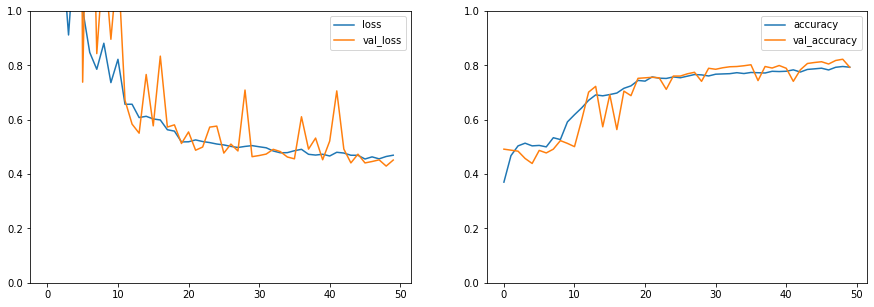

loss =  0.4694635330798103 , val_loss =  0.45161194837688295
accuracy =  0.79324156 , val_accuracy =  0.7929759621620178


In [25]:
c_model_.fit(X_train_c, Y_train_c, 
            epochs = 50, 
            verbose = 1, 
            batch_size = 32, 
            validation_split = 0.1, 
            shuffle=True, 
            callbacks=callbacks)

In [26]:
c_model_.save('./models/class_c_model_tanh_.h5')

loss, acc = c_model_.evaluate(X_test, Y_test)
print("loss =", loss)
print("acc =", acc)

1202/1202 [==============================] - 2s 2ms/step
loss = 0.4632165288171435
acc = 0.7895174622535706


# Whole 학습

In [27]:
import keras 

c_model  = keras.models.load_model('./models/class_c_model_tanh_.h5')
c_model.trainable = False

for layer in c_model.layers:
    layer.trainable = False

d_model  = keras.models.load_model('./models/gan_d_model_tanh_.h5')
d_model.trainable = False

for layer in d_model.layers:
    layer.trainable = False

g_model.trainable = True

/home/hiwony/.local/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [28]:
inputs = Input((128,128,1))
generated = g_model(inputs)
d_output = d_model(generated)
c_output = c_model(generated)

In [29]:
import keras.backend as K

d_r = 0.0005 
u_r = 0.999
c_r = 0.0005

def custom_loss(y_true, y_pred):
    return c_r * K.mean(c_output) + u_r * K.mean(keras.losses.mean_squared_error(inputs, generated)) + d_r * K.mean(d_output)

whole_model = Model(inputs=[inputs], outputs=[d_output, c_output])

whole_model.compile(loss=custom_loss, optimizer='adam', metrics=['accuracy'])
whole_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 128, 128, 1)  17148161    input_7[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            1604609     model_5[1][0]                    
__________________________________________________________________________________________________
classify_model (Model)          (None, 1)            12078161    model_5[1][0]                    
Total params: 30,830,931
Trainable params: 17,136,129
Non-trainable params: 13,694,802
_____

In [30]:
normal_train = np.load('./npy/normal_train_127.npy', allow_pickle=True)

In [31]:
# real = 0, normal = 0 으로 normal_train 개수에 맞춰서 생성 
real = np.zeros(normal_train.shape[0])
normal= np.zeros(normal_train.shape[0])

In [32]:
# normal data로만 학습
hist = whole_model.fit(normal_train, 
                       [real, normal], 
                       validation_split=0.1, 
                       epochs=100, 
                       batch_size=32, 
                       verbose=1,
                       callbacks=callbacks)

Train on 5409 samples, validate on 601 samples
Epoch 1/100
5409/5409 [==============================] - 84s 15ms/step - loss: 0.0584 - model_2_loss: 0.0296 - classify_model_loss: 0.0296 - model_2_accuracy: 0.0198 - classify_model_accuracy: 0.4762 - val_loss: 0.0209 - val_model_2_loss: 0.0105 - val_classify_model_loss: 0.0105 - val_model_2_accuracy: 0.0000e+00 - val_classify_model_accuracy: 0.8303
Epoch 2/100
5409/5409 [==============================] - 70s 13ms/step - loss: 0.0142 - model_2_loss: 0.0071 - classify_model_loss: 0.0071 - model_2_accuracy: 3.6975e-04 - classify_model_accuracy: 0.4729 - val_loss: 0.0078 - val_model_2_loss: 0.0039 - val_classify_model_loss: 0.0039 - val_model_2_accuracy: 0.0000e+00 - val_classify_model_accuracy: 0.8003
Epoch 3/100
5409/5409 [==============================] - 70s 13ms/step - loss: 0.0079 - model_2_loss: 0.0039 - classify_model_loss: 0.0039 - model_2_accuracy: 3.6975e-04 - classify_model_accuracy: 0.4851 - val_loss: 0.0046 - val_model_2_loss: 

Epoch 24/100
5409/5409 [==============================] - 70s 13ms/step - loss: 0.0025 - model_2_loss: 0.0013 - classify_model_loss: 0.0013 - model_2_accuracy: 0.0000e+00 - classify_model_accuracy: 0.4770 - val_loss: 4.3217e-04 - val_model_2_loss: 2.1631e-04 - val_classify_model_loss: 2.1631e-04 - val_model_2_accuracy: 0.0000e+00 - val_classify_model_accuracy: 0.7105
Epoch 25/100
5409/5409 [==============================] - 70s 13ms/step - loss: 0.0024 - model_2_loss: 0.0014 - classify_model_loss: 0.0014 - model_2_accuracy: 1.8488e-04 - classify_model_accuracy: 0.4796 - val_loss: 0.6441 - val_model_2_loss: 0.3211 - val_classify_model_loss: 0.3211 - val_model_2_accuracy: 0.0000e+00 - val_classify_model_accuracy: 0.6273
Epoch 26/100
5409/5409 [==============================] - 70s 13ms/step - loss: 0.0058 - model_2_loss: 0.0029 - classify_model_loss: 0.0029 - model_2_accuracy: 0.0000e+00 - classify_model_accuracy: 0.4833 - val_loss: 0.9338 - val_model_2_loss: 0.4670 - val_classify_model_

5409/5409 [==============================] - 70s 13ms/step - loss: 0.0022 - model_2_loss: 0.0011 - classify_model_loss: 0.0011 - model_2_accuracy: 1.8488e-04 - classify_model_accuracy: 0.4740 - val_loss: 0.0014 - val_model_2_loss: 6.9588e-04 - val_classify_model_loss: 6.9588e-04 - val_model_2_accuracy: 0.0000e+00 - val_classify_model_accuracy: 0.7022
Epoch 47/100
5409/5409 [==============================] - 70s 13ms/step - loss: 0.0021 - model_2_loss: 0.0010 - classify_model_loss: 0.0010 - model_2_accuracy: 1.8488e-04 - classify_model_accuracy: 0.4774 - val_loss: 2.8409e-04 - val_model_2_loss: 1.4952e-04 - val_classify_model_loss: 1.4952e-04 - val_model_2_accuracy: 0.0000e+00 - val_classify_model_accuracy: 0.7720
Epoch 48/100
5409/5409 [==============================] - 70s 13ms/step - loss: 0.0020 - model_2_loss: 0.0010 - classify_model_loss: 0.0010 - model_2_accuracy: 3.6975e-04 - classify_model_accuracy: 0.4836 - val_loss: 5.4293e-04 - val_model_2_loss: 2.7201e-04 - val_classify_mod

5409/5409 [==============================] - 70s 13ms/step - loss: 0.0036 - model_2_loss: 0.0018 - classify_model_loss: 0.0018 - model_2_accuracy: 5.5463e-04 - classify_model_accuracy: 0.4774 - val_loss: 0.0032 - val_model_2_loss: 0.0016 - val_classify_model_loss: 0.0016 - val_model_2_accuracy: 0.0000e+00 - val_classify_model_accuracy: 0.6606
Epoch 69/100
5409/5409 [==============================] - 70s 13ms/step - loss: 0.0020 - model_2_loss: 0.0010 - classify_model_loss: 0.0010 - model_2_accuracy: 0.0000e+00 - classify_model_accuracy: 0.4846 - val_loss: 0.0027 - val_model_2_loss: 0.0014 - val_classify_model_loss: 0.0014 - val_model_2_accuracy: 0.0000e+00 - val_classify_model_accuracy: 0.7022
Epoch 70/100
5409/5409 [==============================] - 70s 13ms/step - loss: 0.0019 - model_2_loss: 9.4766e-04 - classify_model_loss: 9.4766e-04 - model_2_accuracy: 1.8488e-04 - classify_model_accuracy: 0.4792 - val_loss: 0.0042 - val_model_2_loss: 0.0021 - val_classify_model_loss: 0.0021 - va

Epoch 90/100
5409/5409 [==============================] - 70s 13ms/step - loss: 0.0018 - model_2_loss: 8.8311e-04 - classify_model_loss: 8.8311e-04 - model_2_accuracy: 0.0000e+00 - classify_model_accuracy: 0.4822 - val_loss: 3.5611e-04 - val_model_2_loss: 1.7847e-04 - val_classify_model_loss: 1.7847e-04 - val_model_2_accuracy: 0.0000e+00 - val_classify_model_accuracy: 0.7138
Epoch 91/100
5409/5409 [==============================] - 70s 13ms/step - loss: 0.0017 - model_2_loss: 9.0253e-04 - classify_model_loss: 9.0253e-04 - model_2_accuracy: 0.0000e+00 - classify_model_accuracy: 0.4896 - val_loss: 0.0022 - val_model_2_loss: 0.0011 - val_classify_model_loss: 0.0011 - val_model_2_accuracy: 0.0000e+00 - val_classify_model_accuracy: 0.6872
Epoch 92/100
5409/5409 [==============================] - 70s 13ms/step - loss: 0.0022 - model_2_loss: 0.0011 - classify_model_loss: 0.0011 - model_2_accuracy: 3.6975e-04 - classify_model_accuracy: 0.4835 - val_loss: 0.0017 - val_model_2_loss: 8.6898e-04 -

In [33]:
# # normal, fracture섞인 data로 학습

# # real = 0, normal = 0 으로 X_train_c 개수에 맞춰서 생성 
# real = np.zeros(X_train_c.shape[0])
# normal= np.zeros(X_train_c.shape[0])

# hist = whole_model.fit(X_train_c, [real, normal], validation_split=0.1, epochs=20, batch_size=32, verbose=1)

In [34]:
# 모델 저장
whole_model.save('./models/whole_model_tanh.h5')

## Whole 학습 결과

* Input is classified as (Normal, Fracture) : Input Image의 정답
* classified as (Normal, Fracture) : Input Image의 분류 (0:Noraml, 1:Fracture)
* Generated is Discriminated as (Real, Fake) : Generated Image의 판별 (0:Real, 1:Fake)
* Generated is classified as (Noraml, Fracture) : Generated Image의 분류 (0:Noraml, 1:Fracture)


* 최종목표 : Input은 Fracture or Normal 이여도 Generated Image는 Normal이 출력되야된다. 
input = S
1. S(골절) -> G(비골절) = Fracture area (area 출력)
2. S(비골절) -> G(비골절) = Fracture area (미표기) 

In [46]:
# Util 함수

def show_result(target_data=X_test, count=10, threshold=0.2):

    shuffled_index = np.random.permutation(X_test.shape[0])
    shuffled_index = np.arange(0,count)
    model_input_shape = (1,128, 128, 1)

    for i in range(count):
        cl_ = Y_test[i]
        target_input = target_data[shuffled_index[i]]
        c_out = c_model.predict(target_input.reshape(model_input_shape)) 
        g_out = g_model.predict(target_input.reshape(model_input_shape))
        d_out = d_model.predict(g_out)
        c_out_g_in = c_model.predict(g_out)
        
        diff = np.absolute(g_out[0] - target_input)
        diff[diff < threshold] = 0.0

        # 실제 이미지
        if Y_test[i] == 0 :
            print('Input is classified as Normal Image %.1f' % Y_test[i], '(0 : Normal, 1 : Fracture)')
        else : 
            print('Input is classified as Fracture Image %.1f' % Y_test[i], '(0 : Normal, 1 : Fracture)')

        # classify  0 normal, 1 fracture 
        if c_out <= 0.5 :  
            print('Classified as Normal Image %.2f' % c_out, '(0 : Normal, 1 : Fracture)')
        else :
            print('Classified as Fractrue Image %.2f' % c_out, '(0 : Normal, 1 : Fracture)')
        
        # discriminator 0 real 1 fake 디스크리미네이터의 진짜와 가짜
        d_out_ = np.argmax(d_out, axis = 1)
        if d_out_ <= 0.5 :  
            print('Generated is Discriminated as Real Image %.2f' % d_out_, '(0 : Real, 1 : Fake)')
        else : 
            print('Generated is Discriminated as Fake Image %.2f' % d_out_, '(0 : Real, 1 : Fake)')            
        
        # generator_classify 0 normal, 1 fracture
        if c_out_g_in <= 0.5 :  
            print('Generated is classified as Normal Image %.2f' % c_out_g_in, '(0 : Normal, 1 : Fracture)')
        else :
            print('Generated is classified as Fracture Image %.2f' % c_out_g_in, '(0 : Normal, 1 : Fracture)')
        
            
        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        plt.title('Input img')
        plt.axis('off')
        plt.imshow(target_input.reshape((128,128)),cmap='gray' , vmin=0, vmax=1)
        
        plt.subplot(1,3,2)
        plt.title('Generated img')
        plt.axis('off')
        plt.imshow(g_out[0].reshape((128,128)),cmap='gray', vmin=0, vmax=1)
        
        plt.subplot(1,3,3)
        plt.title('Fracture area')
        plt.axis('off')
        plt.imshow(diff.reshape((128,128)),cmap='gray', vmin=0, vmax=1)
        plt.show()
        plt.close()
        print()
#cmap=plt.cm.binary
# show_result(X_test)

Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.26 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.00 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.49 (0 : Normal, 1 : Fracture)


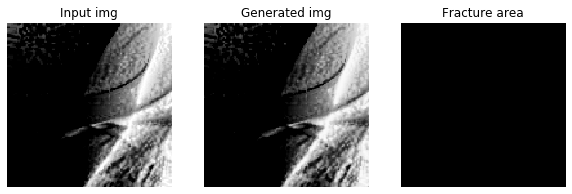


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.49 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.00 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.37 (0 : Normal, 1 : Fracture)


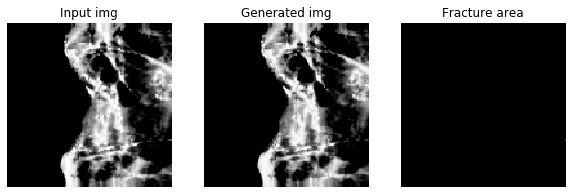


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as Fractrue Image 0.58 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.00 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.60 (0 : Normal, 1 : Fracture)


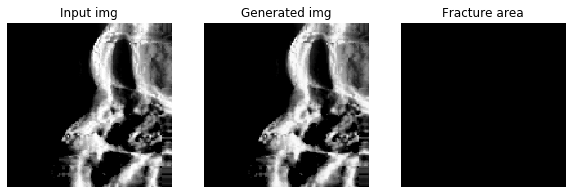


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Fractrue Image 0.67 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.00 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.66 (0 : Normal, 1 : Fracture)


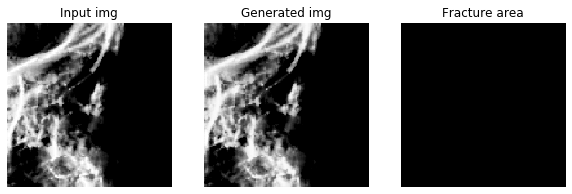


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as Fractrue Image 0.60 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.00 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.73 (0 : Normal, 1 : Fracture)


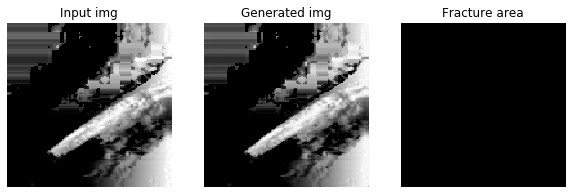


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Fractrue Image 0.63 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.00 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.78 (0 : Normal, 1 : Fracture)


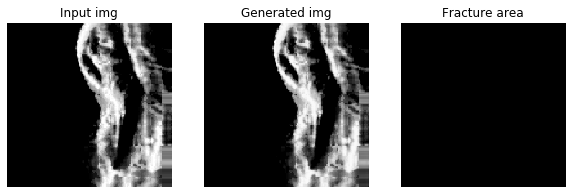


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image -0.01 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.00 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.01 (0 : Normal, 1 : Fracture)


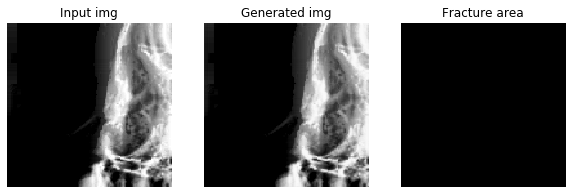


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as Fractrue Image 0.99 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.00 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.99 (0 : Normal, 1 : Fracture)


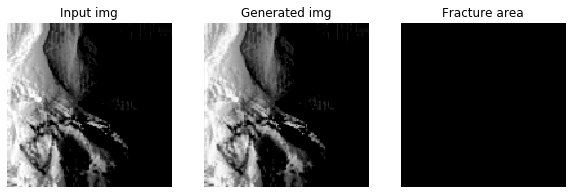


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as Fractrue Image 0.96 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.00 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.96 (0 : Normal, 1 : Fracture)


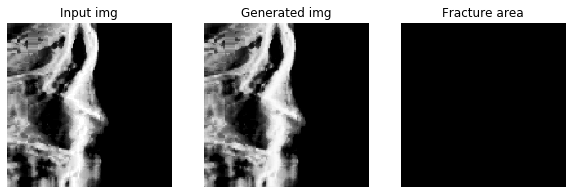


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as Fractrue Image 0.57 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.00 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.48 (0 : Normal, 1 : Fracture)


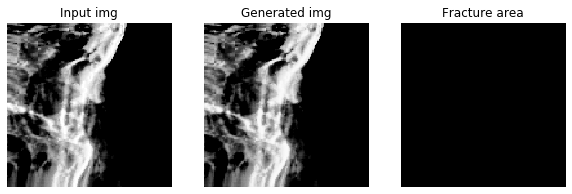

In [51]:
show_result(X_test)